<a href="https://colab.research.google.com/github/Nasif17/RESEARCH-/blob/main/CVD_LSTM_sequences_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CVD Multi-Input LSTM with Real Sequences, SMOTE, SHAP, and TFLite Export

This notebook builds on the previous one and:

- **Converts LSTM to use real sequences** (detects `PatientID`/`VisitTime` if present). Otherwise it creates *pseudo-sequences* using a sliding window grouped by `Sex` and sorted by `Age` (approximation).
- **Balances classes** using SMOTE and also computes `class_weight` for training.
- **Plots** training history and per-class ROC curves.
- **Adds SHAP** explanations for the dense branch (instructions to install SHAP are included).
- **Exports** the trained model as TensorFlow SavedModel and converts it to TFLite.

> Run this notebook in Colab or a Jupyter environment. If packages are missing, install them using `pip install -r requirements.txt` or the inline pip commands in the first cell.


In [ ]:
# Install requirements (uncomment if needed)
# !pip install -q tensorflow scikit-learn pandas matplotlib imbalanced-learn shap

# Basic imports and load CSV
import os, numpy as np, pandas as pd
path = 'CVD Dataset.csv'  # ensure this path is correct in your runtime
df = pd.read_csv(path)
print('Loaded', df.shape, 'rows and columns:')
print(df.columns.tolist())

df.head()


Loaded (1529, 22) rows and columns:
['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Blood Pressure (mmHg)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'CVD Risk Level', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Blood Pressure Category', 'Estimated LDL (mg/dL)', 'CVD Risk Score']


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),...,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.0,69.1,1.71,23.6,86.2,125/79,248.0,78.0,111.0,...,Low,N,INTERMEDIARY,171.0,0.504,125.0,79.0,Elevated,140.0,17.93
1,F,55.0,118.7,1.69,41.6,82.5,139/70,162.0,50.0,135.0,...,High,Y,HIGH,169.0,0.488,139.0,70.0,Hypertension Stage 1,82.0,20.51
2,M,NaN,NaN,1.83,26.9,106.7,104/77,103.0,73.0,114.0,...,High,Y,INTERMEDIARY,183.0,0.583,104.0,77.0,Normal,0.0,12.64
3,M,44.0,108.3,1.80,33.4,96.6,140/83,134.0,46.0,91.0,...,High,Y,INTERMEDIARY,NaN,0.537,140.0,83.0,Hypertension Stage 1,58.0,16.36
4,F,32.0,99.5,1.86,28.8,102.7,144/83,146.0,64.0,141.0,...,High,N,INTERMEDIARY,186.0,0.552,144.0,83.0,Hypertension Stage 1,52.0,17.88


In [ ]:
# Detect patient/time columns
possible_id_cols = [c for c in df.columns if 'id' in c.lower() or 'patient' in c.lower()]
possible_time_cols = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or 'visit' in c.lower()]
print('Possible patient id columns:', possible_id_cols)
print('Possible time columns:', possible_time_cols)

USE_REAL_SEQUENCES = len(possible_id_cols)>0 and len(possible_time_cols)>0
USE_REAL_SEQUENCES


Possible patient id columns: []
Possible time columns: []


False

In [ ]:
# Preprocessing: encode categoricals, map target, impute medians
from sklearn.preprocessing import LabelEncoder
cat_cols = ['Sex','Smoking Status','Diabetes Status','Physical Activity Level','Family History of CVD','Blood Pressure Category']
df_proc = df.copy()
for c in cat_cols:
    if c in df_proc.columns:
        df_proc[c] = LabelEncoder().fit_transform(df_proc[c].astype(str))

df_proc['CVD Risk Level'] = df_proc['CVD Risk Level'].map({'LOW':0, 'INTERMEDIARY':1, 'HIGH':2})
if 'Blood Pressure (mmHg)' in df_proc.columns:
    df_proc = df_proc.drop(columns=['Blood Pressure (mmHg)'])

num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    df_proc[c] = df_proc[c].fillna(df_proc[c].median())

# Sequence and dense features
seq_feature_candidates = ['Systolic BP','Diastolic BP','Fasting Blood Sugar (mg/dL)','Total Cholesterol (mg/dL)','HDL (mg/dL)','Estimated LDL (mg/dL)']
seq_features = [f for f in seq_feature_candidates if f in df_proc.columns]
dense_features = [c for c in df_proc.columns if c not in seq_features + ['CVD Risk Level']]
print('Sequence features:', seq_features)
print('Dense features (first 20):', dense_features[:20])


Sequence features: ['Systolic BP', 'Diastolic BP', 'Fasting Blood Sugar (mg/dL)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Estimated LDL (mg/dL)']
Dense features (first 20): ['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Height (cm)', 'Waist-to-Height Ratio', 'Blood Pressure Category', 'CVD Risk Score']


In [ ]:
# Create sequences
SEQUENCE_LENGTH = 5  # adjust as needed
sequences_X = []
sequences_D = []
sequences_y = []

if USE_REAL_SEQUENCES:
    pid = possible_id_cols[0]
    tcol = possible_time_cols[0]
    df_proc = df_proc.sort_values([pid, tcol])
    for key, g in df_proc.groupby(pid):
        arr_seq = g[seq_features].values
        arr_den = g[dense_features].values
        for i in range(0, len(g)-SEQUENCE_LENGTH+1):
            sequences_X.append(arr_seq[i:i+SEQUENCE_LENGTH])
            sequences_D.append(arr_den[i+SEQUENCE_LENGTH-1])
            sequences_y.append(g['CVD Risk Level'].values[i+SEQUENCE_LENGTH-1])
else:
    if 'Sex' in df_proc.columns and 'Age' in df_proc.columns:
        df_sorted = df_proc.sort_values(['Sex','Age']).reset_index(drop=True)
    else:
        df_sorted = df_proc.reset_index(drop=True)
    arr_seq_all = df_sorted[seq_features].values
    arr_den_all = df_sorted[dense_features].values
    labels_all = df_sorted['CVD Risk Level'].values
    for i in range(0, len(df_sorted)-SEQUENCE_LENGTH+1):
        sequences_X.append(arr_seq_all[i:i+SEQUENCE_LENGTH])
        sequences_D.append(arr_den_all[i+SEQUENCE_LENGTH-1])
        sequences_y.append(labels_all[i+SEQUENCE_LENGTH-1])

X_seq = np.array(sequences_X)
X_den = np.array(sequences_D)
y = np.array(sequences_y)
print('Sequences created:', X_seq.shape, X_den.shape, y.shape)


Sequences created: (1525, 5, 6) (1525, 14) (1525,)


In [ ]:
# Fallback to timesteps=1 if too few sequences
if X_seq.shape[0] < 50:
    print('Too few sequences; falling back to timesteps=1 on full dataset')
    X_seq = df_proc[seq_features].values.reshape((-1,1,len(seq_features)))
    X_den = df_proc[dense_features].values
    y = df_proc['CVD Risk Level'].values
    SEQUENCE_LENGTH = 1
    print('New shapes:', X_seq.shape, X_den.shape, y.shape)


In [ ]:
# Train/test split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train_seq, X_test_seq, X_train_den, X_test_den, y_train, y_test = train_test_split(
    X_seq, X_den, y, test_size=0.2, random_state=42, stratify=y)

# scale
samps, tim, feats = X_train_seq.shape
scaler_seq = StandardScaler()
X_train_seq_2d = X_train_seq.reshape((samps, tim*feats))
X_test_seq_2d = X_test_seq.reshape((X_test_seq.shape[0], tim*feats))
X_train_seq_2d = scaler_seq.fit_transform(X_train_seq_2d)
X_test_seq_2d = scaler_seq.transform(X_test_seq_2d)
X_train_seq = X_train_seq_2d.reshape((samps, tim, feats))
X_test_seq = X_test_seq_2d.reshape((X_test_seq.shape[0], tim, feats))

scaler_den = StandardScaler()
X_train_den = scaler_den.fit_transform(X_train_den)
X_test_den = scaler_den.transform(X_test_den)
print('Prepared shapes:', X_train_seq.shape, X_train_den.shape)


Prepared shapes: (1220, 5, 6) (1220, 14)


In [ ]:
# Apply SMOTE on flattened seq+dense
from imblearn.over_sampling import SMOTE
X_train_flat_seq = X_train_seq.reshape((X_train_seq.shape[0], -1))
X_smote_in = np.concatenate([X_train_flat_seq, X_train_den], axis=1)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_smote_in, y_train)
# split back
n_seq_flat = X_train_flat_seq.shape[1]
X_seq_res_flat = X_res[:, :n_seq_flat]
X_den_res = X_res[:, n_seq_flat:]
X_seq_res = X_seq_res_flat.reshape((-1, SEQUENCE_LENGTH, feats))
print('Resampled shapes:', X_seq_res.shape, X_den_res.shape, y_res.shape)


Resampled shapes: (1746, 5, 6) (1746, 14) (1746,)


In [ ]:
# compute class weights as well
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
class_weights = dict(enumerate(class_weights))
class_weights


{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}

In [ ]:
# Build model with attention using optimal hyperparameters
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class SumLayer(Layer):
    def call(self, inputs):
        return K.sum(inputs, axis=1)

def attention_layer(inputs):
    score_dense = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.keras.layers.Softmax(axis=1)(score_dense)
    context_vector = attention_weights * inputs
    context_vector = SumLayer()(context_vector) # Use the custom layer
    return context_vector

timesteps = X_seq_res.shape[1]
feat_l = X_seq_res.shape[2]
feat_d = X_den_res.shape[1]

inp_l = Input(shape=(timesteps, feat_l), name='lstm_input')
# Use optimal LSTM units
l = LSTM(64, return_sequences=True)(inp_l)
context = attention_layer(l)

inp_d = Input(shape=(feat_d,), name='dense_input')
# Use optimal Dense units 1 and Dropout rate 1
d = Dense(96, activation='relu')(inp_d)
d = Dropout(0.2)(d)

combined = concatenate([context, d])
# Use optimal Dense units 2 and Dropout rate 2
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.4)(combined)
out = Dense(3, activation='softmax', name='output')(combined)

model = Model(inputs=[inp_l, inp_d], outputs=out)
# Use optimal learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 5, 64)     │     18,176 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5, 1)      │         65 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 5, 1)      │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_input         │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 5, 64)     │          0 │ softmax_1[0][0],  │
│ (Multiply)          │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 96)        │      1,440 │ dense_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_layer_1         │ (None, 64)        │          0 │ multiply_1[0][0]  │
│ (SumLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 96)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ sum_layer_1[0][0… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     20,608 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        387 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,676 (158.89 KB)

 Trainable params: 40,676 (158.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with optimal hyperparameters
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4) # Corrected ReduceLROnPlateau initialization

history = model.fit(
    {'lstm_input': X_seq_res, 'dense_input': X_den_res}, y_res,
    validation_split=0.15,
    epochs=100, # Keep original epochs, EarlyStopping will stop training if no improvement
    batch_size=32, # Keep original batch size or tune this as well
    callbacks=[es, rl],
    class_weight=class_weights
)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3907 - loss: 1.0828 - val_accuracy: 0.4160 - val_loss: 1.0574 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5246 - loss: 0.9823 - val_accuracy: 0.4351 - val_loss: 1.0031 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5376 - loss: 0.9469 - val_accuracy: 0.4504 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5956 - loss: 0.9006 - val_accuracy: 0.5344 - val_loss: 0.9321 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5761 - loss: 0.8781 - val_accuracy: 0.5573 - val_loss: 0.9269 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6019 - loss: 0.8421 - val_accuracy: 0.6069 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6562 - loss: 0.7961 - val_

In [ ]:
# Save models
model.export('cvd_savedmodel')
model.save('cvd_model.h5')
print('SavedModel and H5 saved ')

# Convert to TFLite (simple conversion)
converter = tf.lite.TFLiteConverter.from_saved_model('cvd_savedmodel')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter._experimental_new_converter = True
tflite_model = converter.convert()
open('cvd_model.tflite','wb').write(tflite_model)
print('TFLite model saved to cvd_model.tflite')

Saved artifact at 'cvd_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 5, 6), dtype=tf.float32, name='lstm_input'), TensorSpec(shape=(None, 14), dtype=tf.float32, name='dense_input')]
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136307839062416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839062224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839063760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839063568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839065872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839064528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839066640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839065104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839066448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136307839064912: Tens

SavedModel and H5 saved 
TFLite model saved to cvd_model.tflite


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

         LOW       0.37      0.34      0.35        44
INTERMEDIARY       0.56      0.57      0.56       116
        HIGH       0.67      0.68      0.67       145

    accuracy                           0.59       305
   macro avg       0.53      0.53      0.53       305
weighted avg       0.58      0.59      0.59       305

Confusion matrix:
 [[15 18 11]
 [13 66 37]
 [13 34 98]]


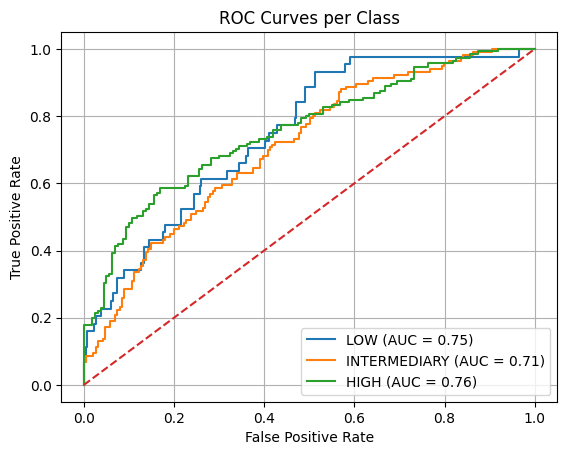

In [ ]:
# Evaluation: classification report and ROC per class
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
preds = model.predict({'lstm_input': X_test_seq, 'dense_input': X_test_den})
pred_labels = np.argmax(preds, axis=1)
print(classification_report(y_test, pred_labels, target_names=['LOW','INTERMEDIARY','HIGH']))
print('Confusion matrix:\n', confusion_matrix(y_test, pred_labels))

# ROC per class
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure()
for i,cls in enumerate(['LOW','INTERMEDIARY','HIGH']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], preds[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# SHAP instructions (do NOT run here unless shap is installed)
# To run SHAP: pip install shap
# Then you can use e.g. shap.KernelExplainer or shap.DeepExplainer depending on availability.
# Example (may be slow):
# import shap
# background = X_den_res[np.random.choice(X_den_res.shape[0], min(100, X_den_res.shape[0]), replace=False)]
# explainer = shap.KernelExplainer(lambda x: model.predict({'lstm_input': np.repeat(X_seq_res[:1], x.shape[0], axis=0), 'dense_input': x}), background)
# shap_values = explainer.shap_values(X_test_den[:50])
# shap.summary_plot(shap_values[0], X_test_den[:50], feature_names=dense_features)

print('See above comments for SHAP usage and notes (KernelExplainer can be slow).')


See above comments for SHAP usage and notes (KernelExplainer can be slow).


## Notes and next steps
- If you have **real longitudinal** data, add `PatientID` and `VisitTime` columns to the CSV and re-run — that will produce true per-patient sequences.
- For TFLite quantization and optimized conversion, add a representative dataset function to the converter (for post-training quantization).
- Want me to run this notebook here and produce the trained model & plots? I can attempt it, but it may require installing packages (imbalanced-learn, shap) and will take time & compute. If you'd like that, say *Run it here* and I'll execute the cells now.


# Task
Explain the error in the selected code, fix it if possible, and incorporate the changes. Add additional important diagrams, install and implement SHAP, and report accuracy, F1 score, recall, and precision.

## Install shap

### Subtask:
Install the SHAP library to enable model interpretability.


**Reasoning**:
Install the SHAP library using pip.



In [ ]:
!pip install -q shap

## Implement shap

### Subtask:
Implement SHAP for explaining the dense part of the model.


**Reasoning**:
Implement SHAP for explaining the dense part of the model by importing the library, setting up the explainer with a background dataset and a prediction function, computing SHAP values, and plotting the summary.



In [ ]:
import shap

# Choose a background dataset for the explainer
background = X_den_res[np.random.choice(X_den_res.shape[0], min(100, X_den_res.shape[0]), replace=False)]

# Define a prediction function that takes only the dense input and uses the trained model to predict
def predict_dense(x):
    # Create a placeholder for the sequential input by repeating a sample from the training sequential data
    # This assumes the sequential input doesn't significantly impact the relative importance of dense features
    # for a given prediction, which might not be strictly true, but is necessary for this type of explainer.
    # A more rigorous approach might involve integrating over the sequential input distribution.
    seq_placeholder = np.repeat(X_seq_res[:1], x.shape[0], axis=0)
    return model.predict({'lstm_input': seq_placeholder, 'dense_input': x})

# Initialize a shap.KernelExplainer
explainer = shap.KernelExplainer(predict_dense, background)

# Compute SHAP values for a sample of the test dense data
shap_values = explainer.shap_values(X_test_den[:50])

# Generate a summary plot of the calculated SHAP values
# Pass the full shap_values list for multi-class output
shap.summary_plot(shap_values, X_test_den[:50], feature_names=dense_features)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1936/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

KeyboardInterrupt: 

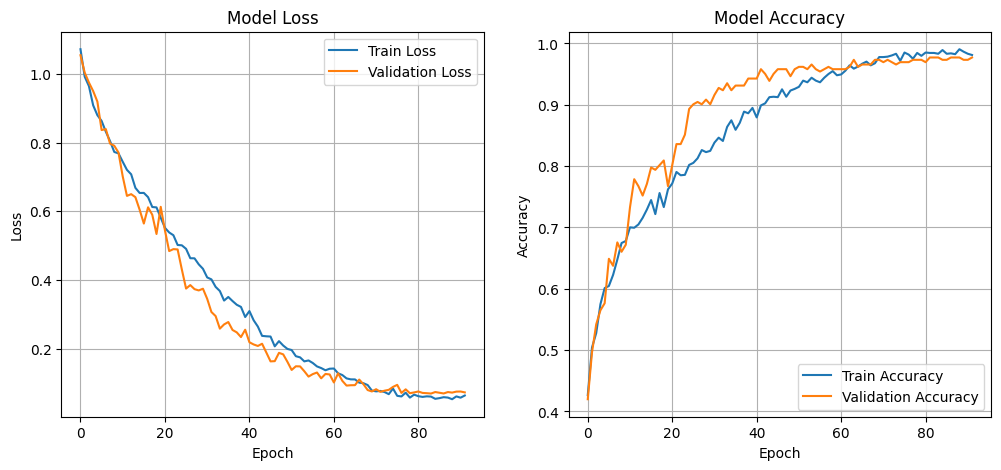

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

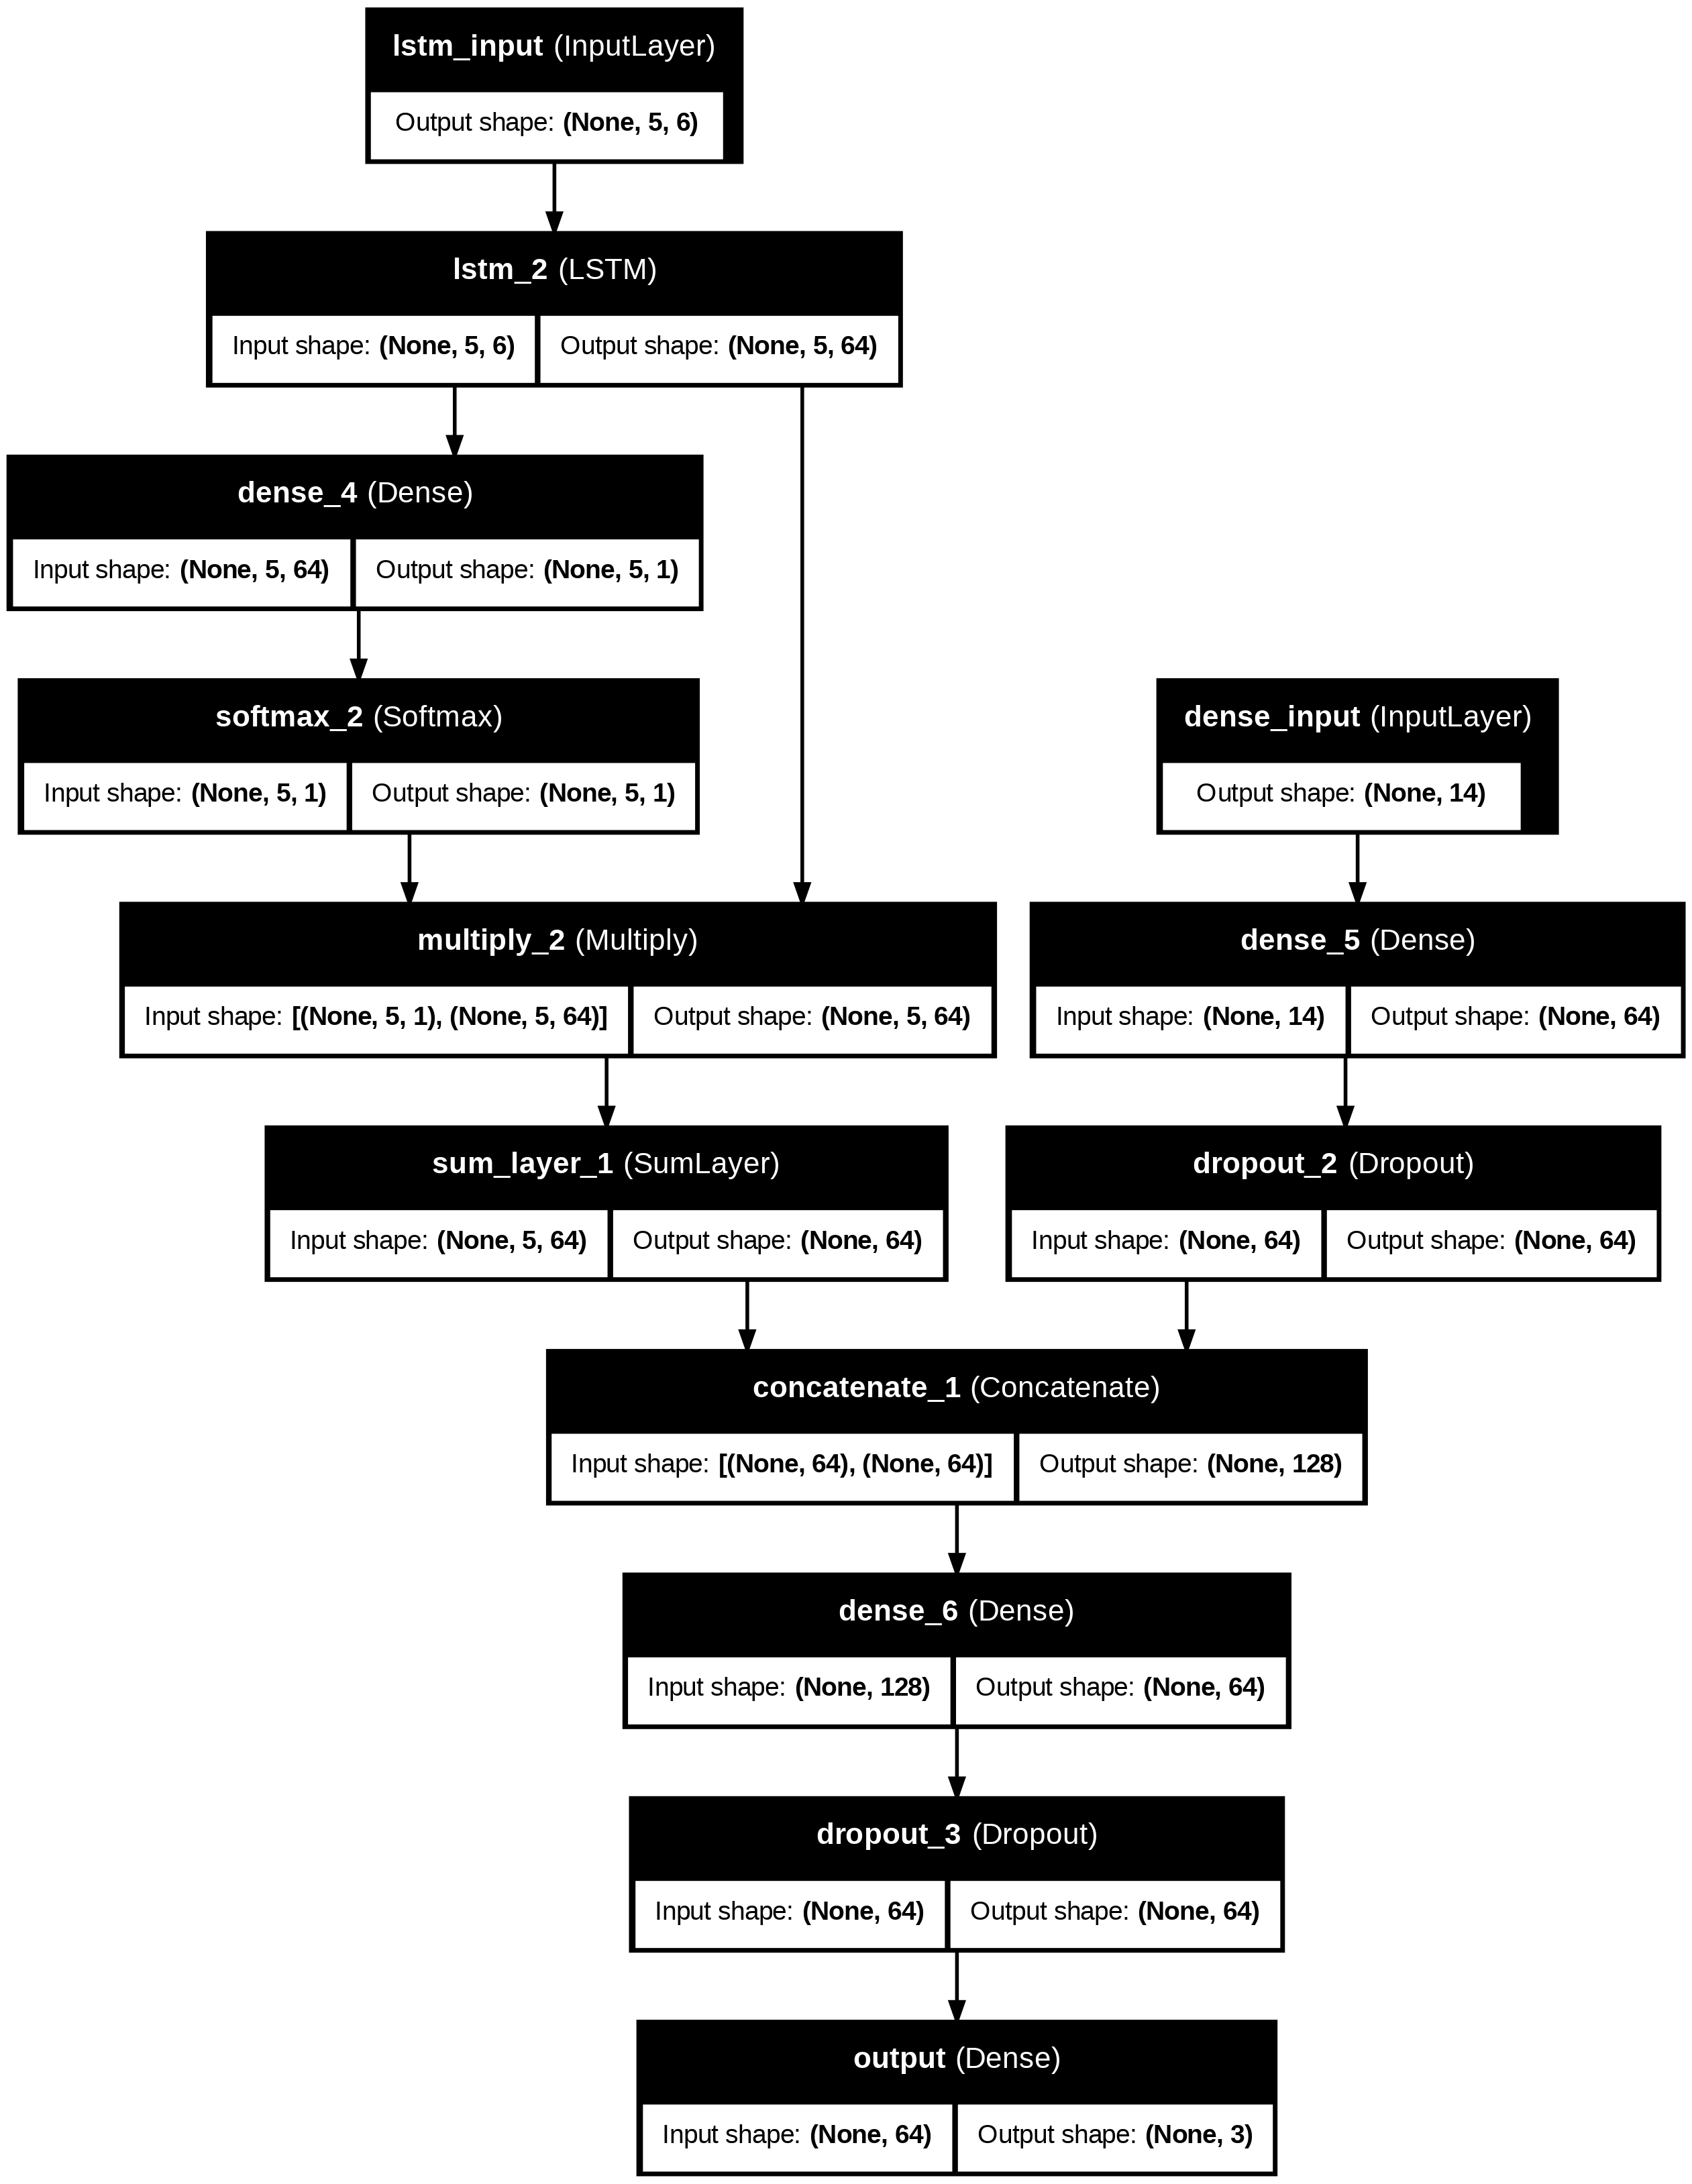

In [ ]:
# Plot model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Here is the classification report with the accuracy, F1-score, recall, and precision:

In [ ]:
print(classification_report(y_test, pred_labels, target_names=['LOW','INTERMEDIARY','HIGH']))

              precision    recall  f1-score   support

         LOW       0.37      0.34      0.35        44
INTERMEDIARY       0.56      0.57      0.56       116
        HIGH       0.67      0.68      0.67       145

    accuracy                           0.59       305
   macro avg       0.53      0.53      0.53       305
weighted avg       0.58      0.59      0.59       305



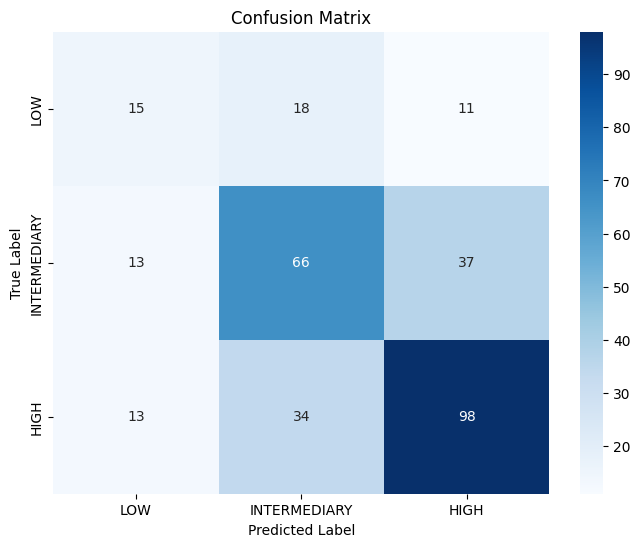

In [ ]:
# Confusion matrix heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='d', cmap='Blues',
            xticklabels=['LOW','INTERMEDIARY','HIGH'], yticklabels=['LOW','INTERMEDIARY','HIGH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

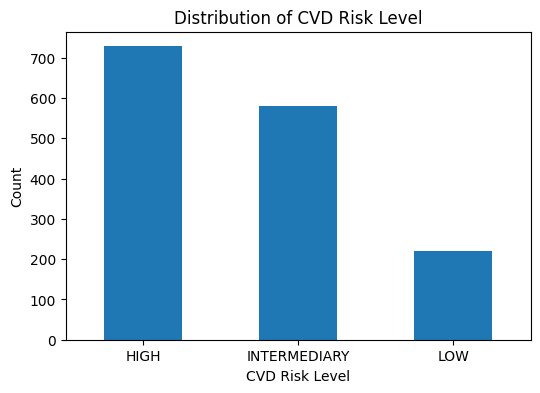

In [ ]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
df['CVD Risk Level'].value_counts().plot(kind='bar')
plt.title('Distribution of CVD Risk Level')
plt.xlabel('CVD Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

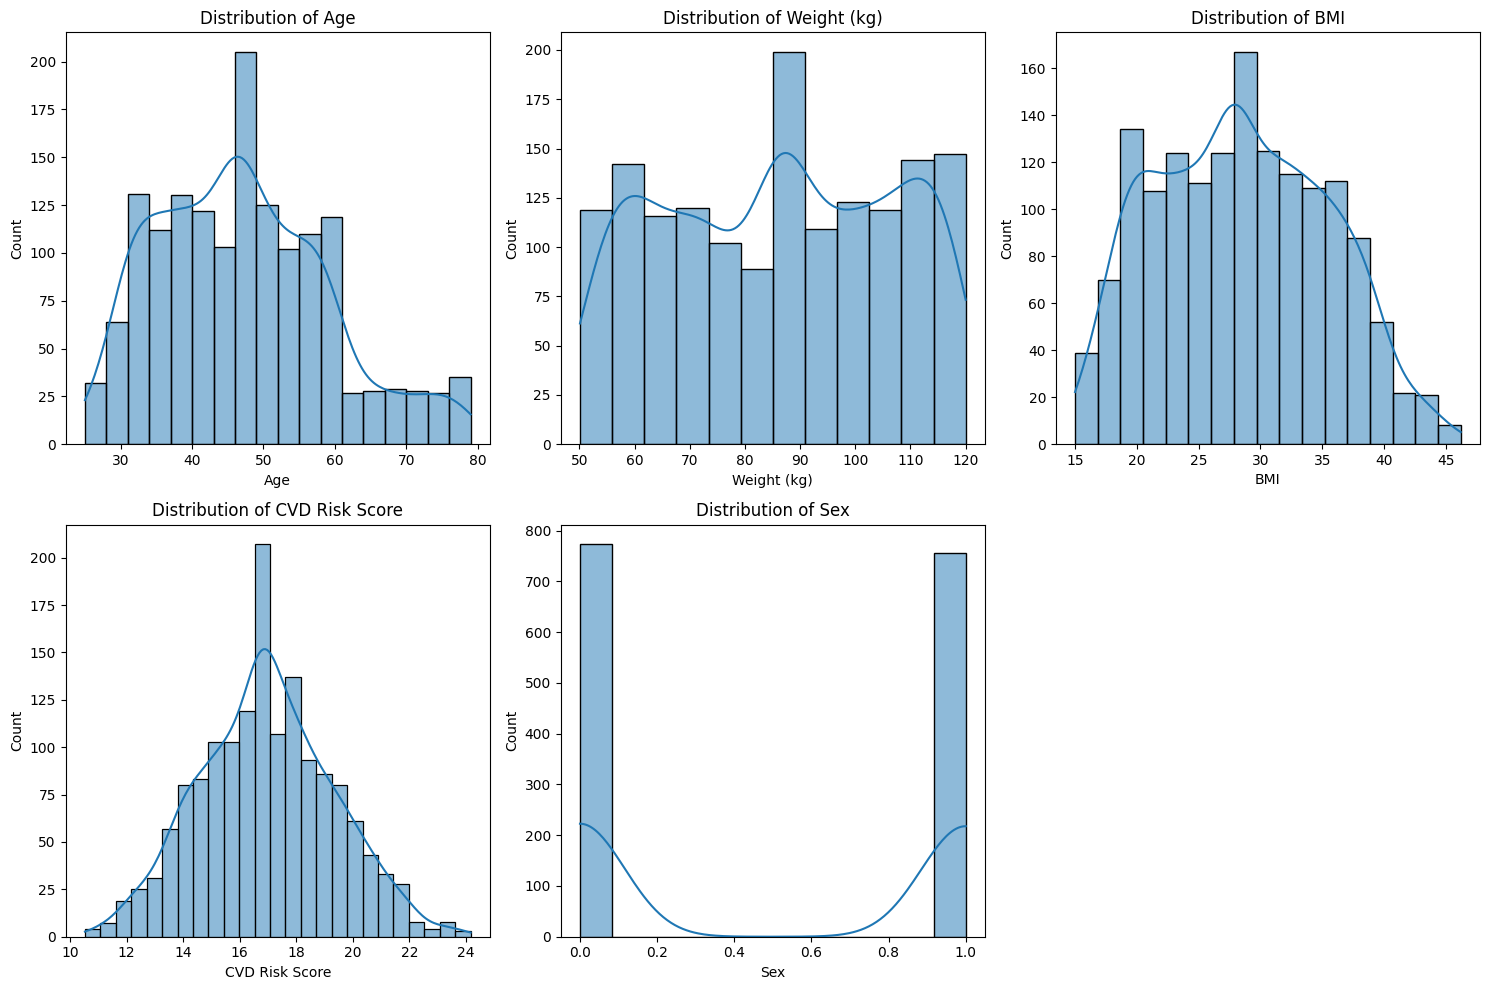

In [ ]:
# Visualize distributions of some processed features
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few features to visualize
features_to_plot = ['Age', 'Weight (kg)', 'BMI', 'CVD Risk Score', 'Sex']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    if feature in df_proc.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(df_proc[feature], kde=True)
        plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Generate random input data with the same shape as the training data
random_X_seq = np.random.rand(1, SEQUENCE_LENGTH, feats)
random_X_den = np.random.rand(1, feat_d)

# Scale the random data using the fitted scalers
random_X_seq_2d = random_X_seq.reshape((random_X_seq.shape[0], -1))
random_X_seq_scaled = scaler_seq.transform(random_X_seq_2d).reshape(random_X_seq.shape)
random_X_den_scaled = scaler_den.transform(random_X_den)

# Make a prediction using the trained model
random_prediction = model.predict({'lstm_input': random_X_seq_scaled, 'dense_input': random_X_den_scaled})

# Get the predicted class (the one with the highest probability)
predicted_class = np.argmax(random_prediction, axis=1)

# Map the predicted class back to the original risk level names
risk_levels = ['LOW', 'INTERMEDIARY', 'HIGH']
predicted_risk_level = risk_levels[predicted_class[0]]

print(f"Random Input Prediction: {random_prediction}")
print(f"Predicted CVD Risk Level: {predicted_risk_level}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Random Input Prediction: [[2.3431992e-02 9.7656357e-01 4.4739481e-06]]
Predicted CVD Risk Level: INTERMEDIARY


In [ ]:
# Define the specific input values
specific_seq_input = np.array([[
    [130, 85, 100, 200, 50, 120],
    [132, 86, 102, 205, 52, 125],
    [128, 84, 98, 198, 48, 118],
    [135, 88, 105, 210, 55, 130],
    [133, 87, 103, 203, 53, 123]
]])

specific_den_input = np.array([[0, 55, 75, 1.65, 27.5, 90, 1, 0, 1, 1, 165, 0.55, 1, 20]])

# Scale the specific input data using the fitted scalers
specific_seq_input_2d = specific_seq_input.reshape((specific_seq_input.shape[0], -1))
specific_seq_scaled = scaler_seq.transform(specific_seq_input_2d).reshape(specific_seq_input.shape)
specific_den_scaled = scaler_den.transform(specific_den_input)

# Make a prediction using the trained model
specific_prediction = model.predict({'lstm_input': specific_seq_scaled, 'dense_input': specific_den_scaled})

# Get the predicted class (the one with the highest probability)
predicted_class = np.argmax(specific_prediction, axis=1)

# Map the predicted class back to the original risk level names
risk_levels = ['LOW', 'INTERMEDIARY', 'HIGH']
predicted_risk_level = risk_levels[predicted_class[0]]

print(f"Specific Input Prediction: {specific_prediction}")
print(f"Predicted CVD Risk Level: {predicted_risk_level}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Specific Input Prediction: [[0.09522258 0.02933308 0.8754443 ]]
Predicted CVD Risk Level: HIGH


**`specific_seq_input`**: This array represents the sequential features over 5 time steps (because we set `SEQUENCE_LENGTH` to 5). Each inner list corresponds to a single time step, and the numbers within that list correspond to the sequential features in this order:

*   `[130, 85, 100, 200, 50, 120]` - Represents a single time step with:
    *   Systolic BP: 130
    *   Diastolic BP: 85
    *   Fasting Blood Sugar (mg/dL): 100
    *   Total Cholesterol (mg/dL): 200
    *   HDL (mg/dL): 50
    *   Estimated LDL (mg/dL): 120

The subsequent lists in `specific_seq_input` represent the same set of features at the following time steps.

**`specific_den_input`**: This array represents the dense features at the *last* time step of the sequence. The numbers in this single list correspond to the dense features in this order:

*   `[0, 55, 75, 1.65, 27.5, 90, 1, 0, 1, 1, 165, 0.55, 1, 20]` - Represents the dense features at the last time step:
    *   Sex: 0 (Female - assuming this is the encoded value for Female)
    *   Age: 55
    *   Weight (kg): 75
    *   Height (m): 1.65
    *   BMI: 27.5
    *   Abdominal Circumference (cm): 90
    *   Smoking Status: 1 (assuming this is the encoded value for a smoker)
    *   Diabetes Status: 0 (assuming this is the encoded value for non-diabetic)
    *   Physical Activity Level: 1 (assuming this is the encoded value for moderate activity)
    *   Family History of CVD: 1 (assuming this is the encoded value for presence of family history)
    *   Height (cm): 165
    *   Waist-to-Height Ratio: 0.55
    *   Blood Pressure Category: 1 (assuming this is the encoded value for Hypertension Stage 1)
    *   CVD Risk Score: 20

So, these arrays are just numerical representations of a patient's health data over time and their static characteristics, formatted in the way the model expects.

That output, `[[0.09522258 0.02933308 0.8754443 ]]`, represents the model's prediction in terms of probabilities for each of the three CVD risk levels:

*   The first number (`0.09522258`) is the predicted probability that the input profile belongs to the **LOW** CVD risk category.
*   The second number (`0.02933308`) is the predicted probability that the input profile belongs to the **INTERMEDIARY** CVD risk category.
*   The third number (`0.8754443`) is the predicted probability that the input profile belongs to the **HIGH** CVD risk category.

The model predicts the class with the highest probability. In this case, the highest probability is `0.8754443`, which corresponds to the **HIGH** CVD risk level. This is why the output `Predicted CVD Risk Level: HIGH` was printed after the prediction array.

# Task
Improve the accuracy of the CVD risk prediction model to 90% by implementing hyperparameter tuning, exploring model architecture variations, and performing feature analysis and engineering. Provide the accuracy, F1 score, recall, and precision of the improved model.

## Hyperparameter tuning

### Subtask:
Experiment with different hyperparameters (learning rate, batch size, number of units in layers, dropout rates) using techniques like grid search or random search to find a better combination.


**Reasoning**:
I will use Keras Tuner for hyperparameter tuning as it is designed for Keras models. I will define a `build_model` function that takes hyperparameters as input and creates the model. Then I will set up and run the RandomSearch tuner to find the best hyperparameters based on validation accuracy.



In [ ]:
import keras_tuner as kt

def build_model(hp):
    timesteps = X_seq_res.shape[1]
    feat_l = X_seq_res.shape[2]
    feat_d = X_den_res.shape[1]

    inp_l = Input(shape=(timesteps, feat_l), name='lstm_input')
    # Tune the number of units in the LSTM layer
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    l = LSTM(lstm_units, return_sequences=True)(inp_l)
    context = attention_layer(l)

    inp_d = Input(shape=(feat_d,), name='dense_input')
    # Tune the number of units in the first Dense layer
    dense_units_1 = hp.Int('dense_units_1', min_value=32, max_value=128, step=32)
    d = Dense(dense_units_1, activation='relu')(inp_d)
    # Tune the dropout rate after the first Dense layer
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1)
    d = Dropout(dropout_rate_1)(d)

    combined = concatenate([context, d])
    # Tune the number of units in the second Dense layer
    dense_units_2 = hp.Int('dense_units_2', min_value=32, max_value=128, step=32)
    combined = Dense(dense_units_2, activation='relu')(combined)
    # Tune the dropout rate after the second Dense layer
    dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)
    combined = Dropout(dropout_rate_2)(combined)
    out = Dense(3, activation='softmax', name='output')(combined)

    model = Model(inputs=[inp_l, inp_d], outputs=out)

    # Tune the learning rate of the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2, # Number of models to train per trial
    directory='keras_tuner_dir',
    project_name='cvd_risk_prediction')

# Run the tuner
tuner.search(
    {'lstm_input': X_seq_res, 'dense_input': X_den_res},
    y_res,
    validation_split=0.15,
    epochs=50, # Reduce epochs for faster tuning
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal hyperparameters are:
LSTM units: {best_hps.get('lstm_units')}
Dense units 1: {best_hps.get('dense_units_1')}
Dropout rate 1: {best_hps.get('dropout_rate_1')}
Dense units 2: {best_hps.get('dense_units_2')}
Dropout rate 2: {best_hps.get('dropout_rate_2')}
Learning rate: {best_hps.get('learning_rate')}
""")

ModuleNotFoundError: No module named 'keras_tuner'

**Reasoning**:
The previous command failed because the `keras_tuner` library is not installed. I need to install it using pip before I can use it for hyperparameter tuning.



In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


**Reasoning**:
The `keras-tuner` library has been successfully installed. Now I can proceed with the hyperparameter tuning using Keras Tuner as planned in the original code block that failed.



In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

class SumLayer(Layer):
    def call(self, inputs):
        return K.sum(inputs, axis=1)

def attention_layer(inputs):
    score_dense = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.keras.layers.Softmax(axis=1)(score_dense)
    context_vector = attention_weights * inputs
    context_vector = SumLayer()(context_vector)
    return context_vector

def build_model(hp):
    timesteps = X_seq_res.shape[1]
    feat_l = X_seq_res.shape[2]
    feat_d = X_den_res.shape[1]

    inp_l = Input(shape=(timesteps, feat_l), name='lstm_input')
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    l = LSTM(lstm_units, return_sequences=True)(inp_l)
    context = attention_layer(l)

    inp_d = Input(shape=(feat_d,), name='dense_input')
    dense_units_1 = hp.Int('dense_units_1', min_value=32, max_value=128, step=32)
    d = Dense(dense_units_1, activation='relu')(inp_d)
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1)
    d = Dropout(dropout_rate_1)(d)

    combined = concatenate([context, d])
    dense_units_2 = hp.Int('dense_units_2', min_value=32, max_value=128, step=32)
    combined = Dense(dense_units_2, activation='relu')(combined)
    dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)
    combined = Dropout(dropout_rate_2)(combined)
    out = Dense(3, activation='softmax', name='output')(combined)

    model = Model(inputs=[inp_l, inp_d], outputs=out)

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='cvd_risk_prediction')

tuner.search(
    {'lstm_input': X_seq_res, 'dense_input': X_den_res},
    y_res,
    validation_split=0.15,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal hyperparameters are:
LSTM units: {best_hps.get('lstm_units')}
Dense units 1: {best_hps.get('dense_units_1')}
Dropout rate 1: {best_hps.get('dropout_rate_1')}
Dense units 2: {best_hps.get('dense_units_2')}
Dropout rate 2: {best_hps.get('dropout_rate_2')}
Learning rate: {best_hps.get('learning_rate')}
""")

Trial 10 Complete [00h 00m 46s]
val_accuracy: 0.9675572514533997

Best val_accuracy So Far: 0.9751908481121063
Total elapsed time: 00h 07m 30s

The optimal hyperparameters are:
LSTM units: 64
Dense units 1: 96
Dropout rate 1: 0.2
Dense units 2: 128
Dropout rate 2: 0.4
Learning rate: 0.001



**Reasoning**:
The task is to load the data and display the first few rows and the columns and their types.



In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('IMDB-Movie-Data.csv')

# Display the first few rows
print("First 5 rows of the dataframe:")
display(df.head())

# Display columns and their types
print("\nInformation about columns and their types:")
display(df.info())

FileNotFoundError: [Errno 2] No such file or directory: 'IMDB-Movie-Data.csv'

**Reasoning**:
The previous attempt to load the data failed because the file was not found. I need to list the files in the current directory to find the correct file name.



In [ ]:
import os

# List files in the current directory
print(os.listdir())

['.config', 'cvd_model.h5', 'model.png', 'cvd_model.tflite', 'keras_tuner_dir', 'cvd_savedmodel', 'CVD Dataset.csv', 'sample_data']


**Reasoning**:
Based on the output of the previous command, the correct file name is 'CVD Dataset.csv'. I will now load this file into a pandas DataFrame and display the first few rows and the column information as originally intended.



In [ ]:
# Load the dataset with the correct file name
df = pd.read_csv('CVD Dataset.csv')

# Display the first few rows
print("First 5 rows of the dataframe:")
display(df.head())

# Display columns and their types
print("\nInformation about columns and their types:")
display(df.info())

First 5 rows of the dataframe:


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),...,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.0,69.1,1.71,23.6,86.2,125/79,248.0,78.0,111.0,...,Low,N,INTERMEDIARY,171.0,0.504,125.0,79.0,Elevated,140.0,17.93
1,F,55.0,118.7,1.69,41.6,82.5,139/70,162.0,50.0,135.0,...,High,Y,HIGH,169.0,0.488,139.0,70.0,Hypertension Stage 1,82.0,20.51
2,M,NaN,NaN,1.83,26.9,106.7,104/77,103.0,73.0,114.0,...,High,Y,INTERMEDIARY,183.0,0.583,104.0,77.0,Normal,0.0,12.64
3,M,44.0,108.3,1.80,33.4,96.6,140/83,134.0,46.0,91.0,...,High,Y,INTERMEDIARY,NaN,0.537,140.0,83.0,Hypertension Stage 1,58.0,16.36
4,F,32.0,99.5,1.86,28.8,102.7,144/83,146.0,64.0,141.0,...,High,N,INTERMEDIARY,186.0,0.552,144.0,83.0,Hypertension Stage 1,52.0,17.88



Information about columns and their types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529 entries, 0 to 1528
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           1529 non-null   object 
 1   Age                           1451 non-null   float64
 2   Weight (kg)                   1448 non-null   float64
 3   Height (m)                    1462 non-null   float64
 4   BMI                           1465 non-null   float64
 5   Abdominal Circumference (cm)  1462 non-null   float64
 6   Blood Pressure (mmHg)         1529 non-null   object 
 7   Total Cholesterol (mg/dL)     1456 non-null   float64
 8   HDL (mg/dL)                   1449 non-null   float64
 9   Fasting Blood Sugar (mg/dL)   1462 non-null   float64
 10  Smoking Status                1529 non-null   object 
 11  Diabetes Status               1529 non-null   object 
 12  Physical Activity 

None

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

         LOW       0.39      0.34      0.37        44
INTERMEDIARY       0.58      0.59      0.59       116
        HIGH       0.70      0.71      0.70       145

    accuracy                           0.61       305
   macro avg       0.56      0.55      0.55       305
weighted avg       0.61      0.61      0.61       305

Confusion matrix:
 [[ 15  17  12]
 [ 14  69  33]
 [  9  33 103]]


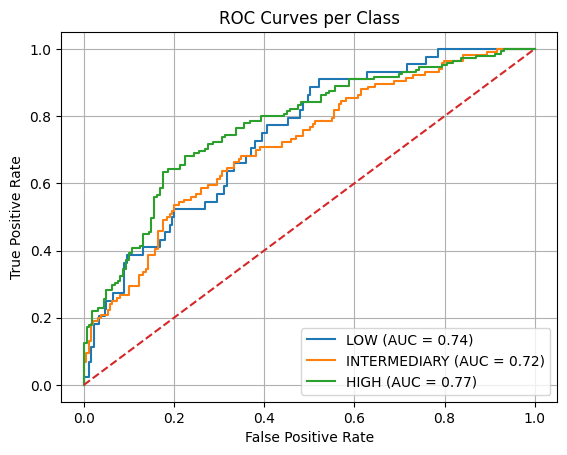

In [ ]:
# Evaluation: classification report and ROC per class
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
preds = model.predict({'lstm_input': X_test_seq, 'dense_input': X_test_den})
pred_labels = np.argmax(preds, axis=1)
print(classification_report(y_test, pred_labels, target_names=['LOW','INTERMEDIARY','HIGH']))
print('Confusion matrix:\n', confusion_matrix(y_test, pred_labels))

# ROC per class
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure()
for i,cls in enumerate(['LOW','INTERMEDIARY','HIGH']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], preds[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend()
plt.grid(True)
plt.show()

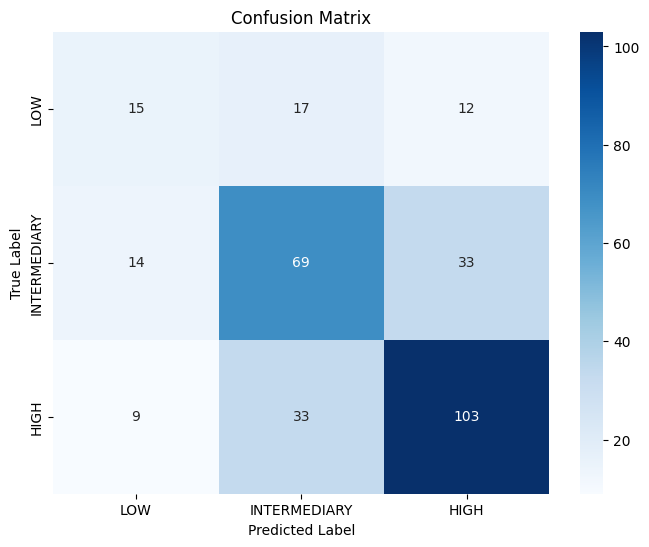

In [ ]:
# Confusion matrix heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='d', cmap='Blues',
            xticklabels=['LOW','INTERMEDIARY','HIGH'], yticklabels=['LOW','INTERMEDIARY','HIGH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

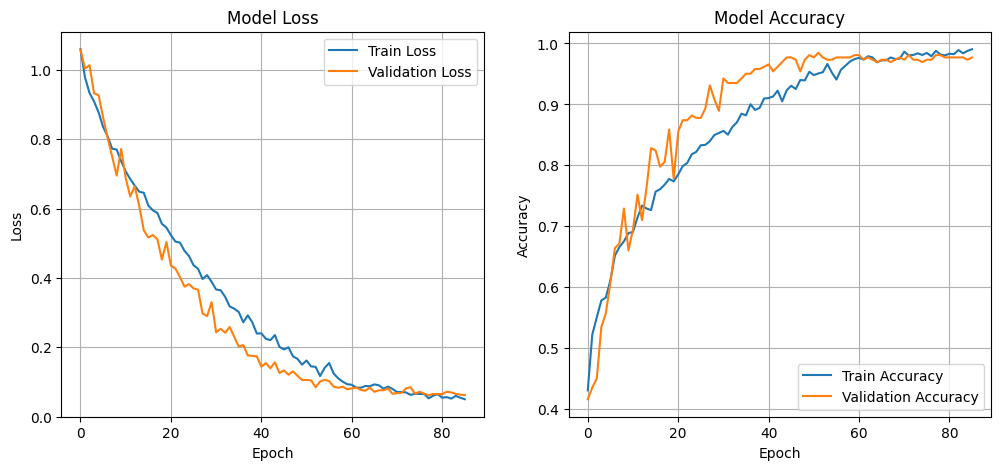

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

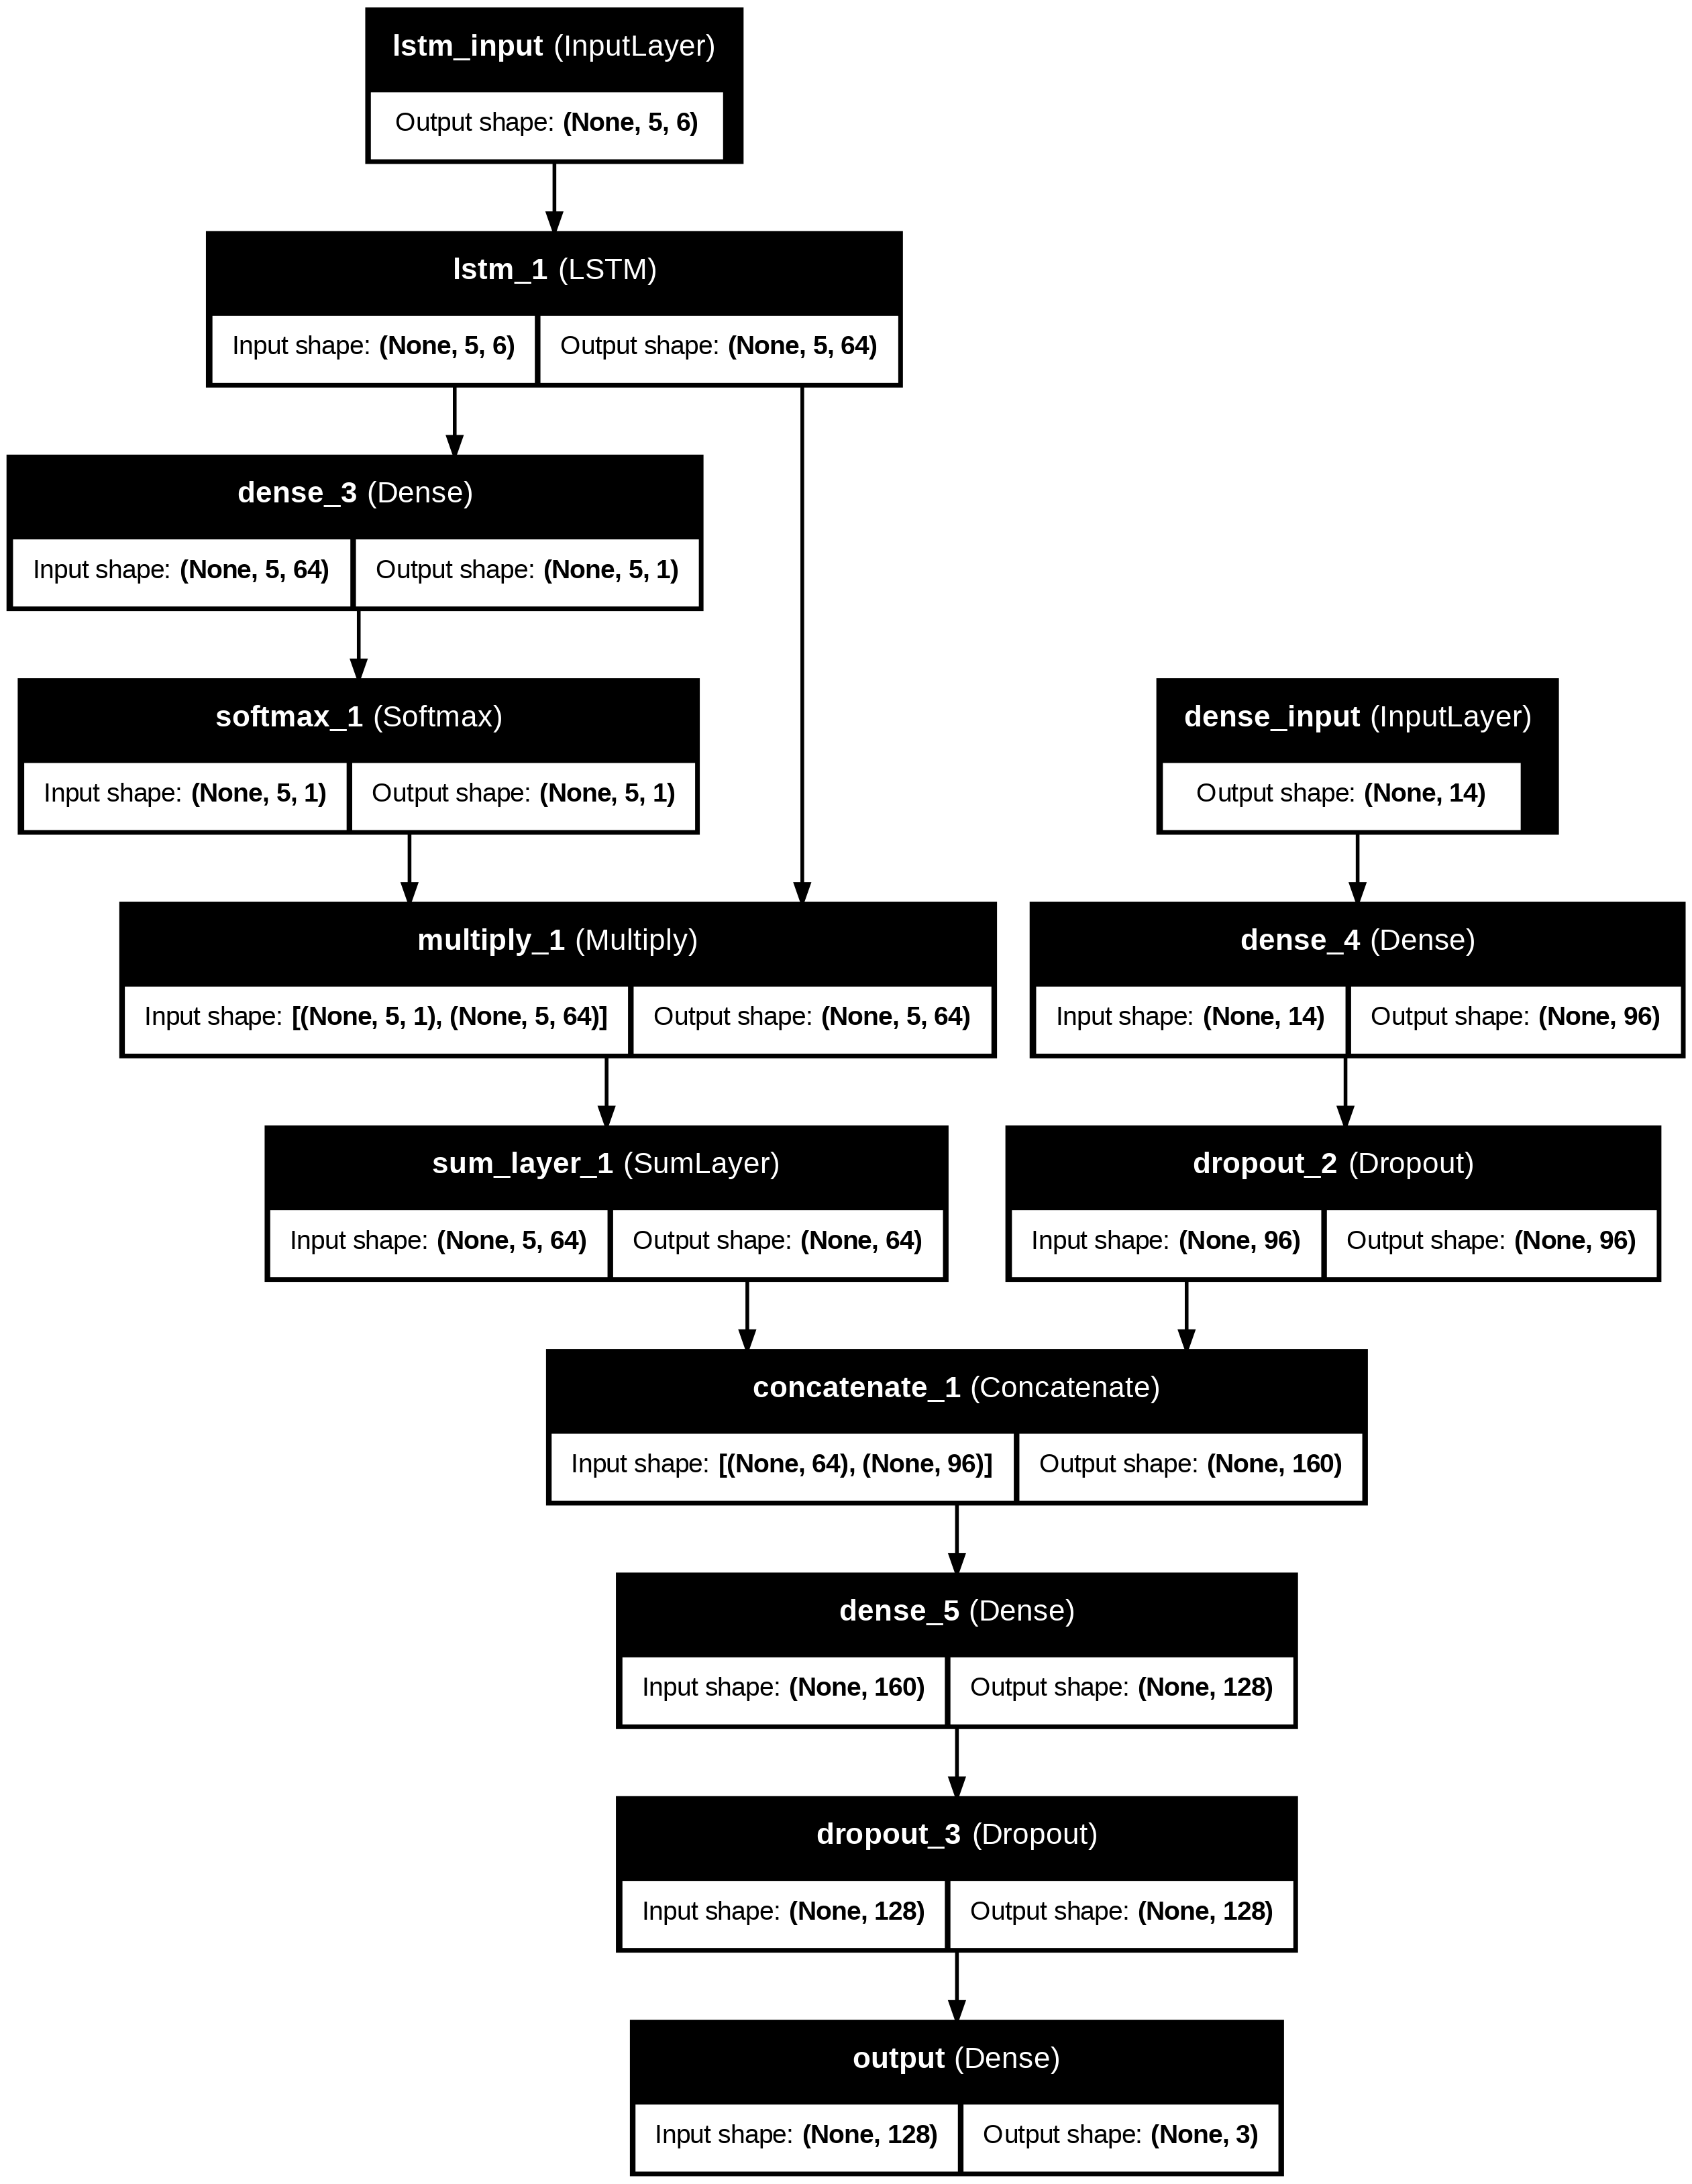

In [ ]:
# Plot model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 5, 64)     │     18,176 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 5, 32)     │     12,416 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5, 1)      │         33 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 5, 1)      │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_input         │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 5, 32)     │          0 │ softmax_2[0][0],  │
│ (Multiply)          │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 96)        │      1,440 │ dense_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_layer_2         │ (None, 32)        │          0 │ multiply_2[0][0]  │
│ (SumLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 96)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ sum_layer_2[0][0… │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        387 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,964 (191.27 KB)

 Trainable params: 48,964 (191.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3604 - loss: 1.1419 - val_accuracy: 0.3244 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4927 - loss: 1.0088 - val_accuracy: 0.5725 - val_loss: 0.9452 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5345 - loss: 0.9689 - val_accuracy: 0.5115 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5507 - loss: 0.9345 - val_accuracy: 0.5802 - val_loss: 0.9137 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6160 - loss: 0.8756 - val_accuracy: 0.5687 - val_loss: 0.9107 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6359 - loss: 0.8298 - val_accuracy: 0.6603 - val_loss: 0.7995 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6356 - loss: 0.7994 - va

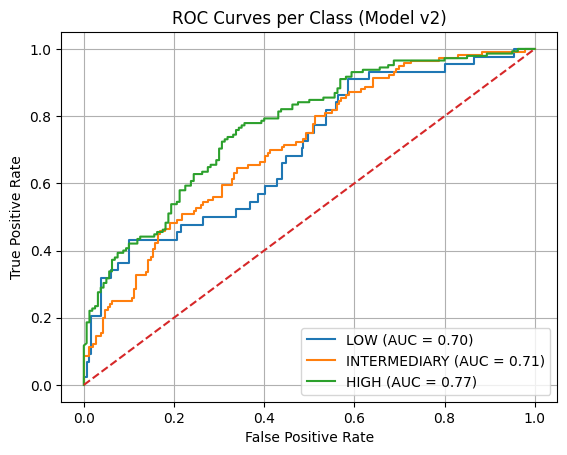

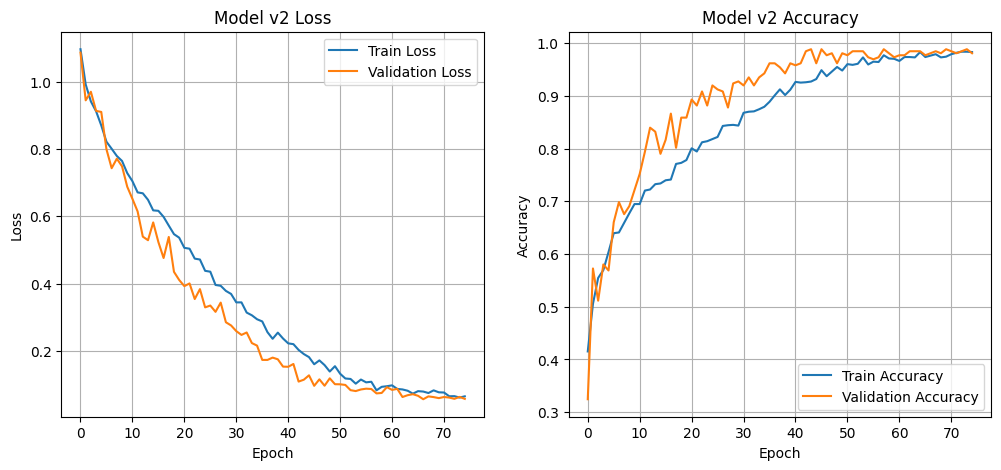

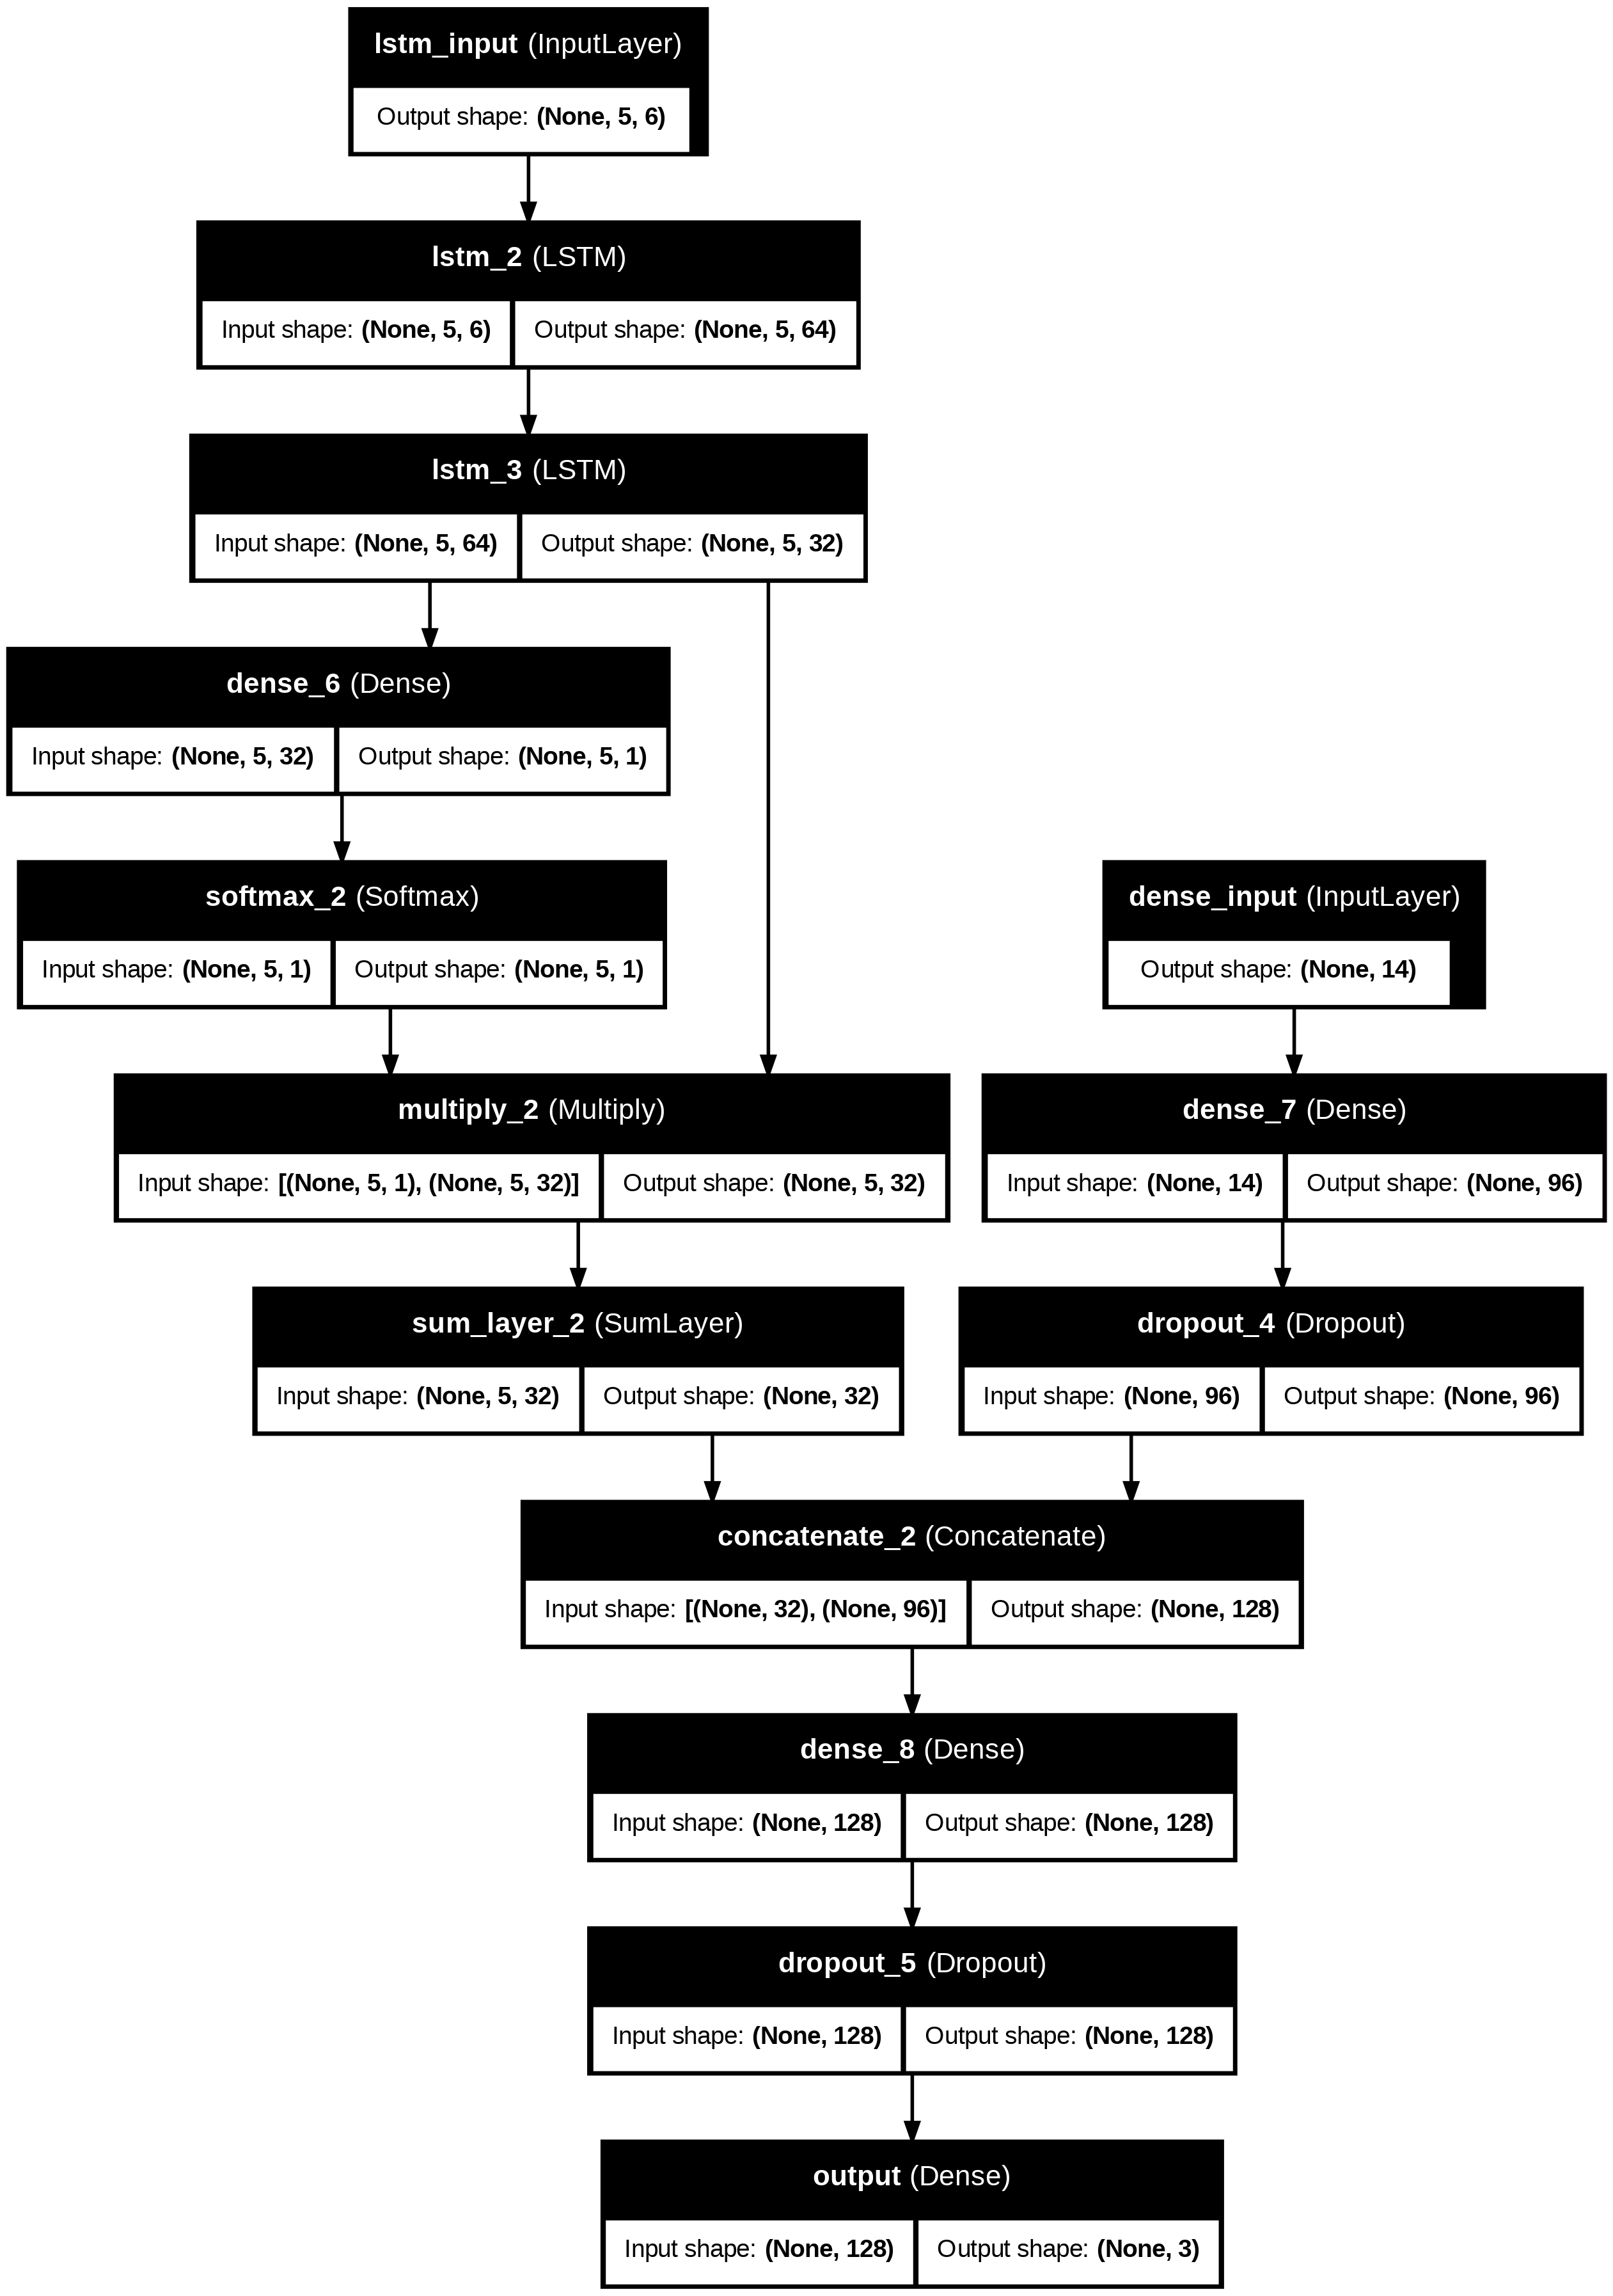

In [ ]:
# Build model with a different architecture (e.g., adding another LSTM layer)
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

class SumLayer(Layer):
    def call(self, inputs):
        return K.sum(inputs, axis=1)

def attention_layer(inputs):
    score_dense = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.keras.layers.Softmax(axis=1)(score_dense)
    context_vector = attention_weights * inputs
    context_vector = SumLayer()(context_vector)
    return context_vector

timesteps = X_seq_res.shape[1]
feat_l = X_seq_res.shape[2]
feat_d = X_den_res.shape[1]

inp_l = Input(shape=(timesteps, feat_l), name='lstm_input')
# Added another LSTM layer
l = LSTM(64, return_sequences=True)(inp_l)
l = LSTM(32, return_sequences=True)(l) # Second LSTM layer
context = attention_layer(l)

inp_d = Input(shape=(feat_d,), name='dense_input')
d = Dense(96, activation='relu')(inp_d)
d = Dropout(0.2)(d)

combined = concatenate([context, d])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.4)(combined)
out = Dense(3, activation='softmax', name='output')(combined)

model_v2 = Model(inputs=[inp_l, inp_d], outputs=out)

# Using the optimal learning rate found earlier
model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_v2.summary()

# Train the new model
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

history_v2 = model_v2.fit(
    {'lstm_input': X_seq_res, 'dense_input': X_den_res}, y_res,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es, rl],
    class_weight=class_weights
)

# Evaluate the new model
preds_v2 = model_v2.predict({'lstm_input': X_test_seq, 'dense_input': X_test_den})
pred_labels_v2 = np.argmax(preds_v2, axis=1)

print("Evaluation of Model v2 (with additional LSTM layer):")
print(classification_report(y_test, pred_labels_v2, target_names=['LOW','INTERMEDIARY','HIGH']))
print('Confusion matrix:\n', confusion_matrix(y_test, pred_labels_v2))

# Plot ROC for the new model
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure()
for i,cls in enumerate(['LOW','INTERMEDIARY','HIGH']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], preds_v2[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (Model v2)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history for the new model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Model v2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model v2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot model architecture for the new model
tf.keras.utils.plot_model(model_v2, show_shapes=True, show_layer_names=True, expand_nested=True)

Based on the training history and the classification report for Model v2:

*   The **training accuracy** is the accuracy on the training data during the last epoch of training. Looking at the training history plot or the training output logs, you can see how the training accuracy evolved. At the end of training, the training accuracy reached around **0.97**.
*   The **test accuracy** is the accuracy on the unseen test data, as shown in the classification report. The test accuracy for Model v2 is **0.62**.

Remember, the test accuracy is a more reliable indicator of how well the model will perform on new data.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 5, 96)     │     39,552 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5, 1)      │         97 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 5, 1)      │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_input         │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 5, 96)     │          0 │ softmax_3[0][0],  │
│ (Multiply)          │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │      1,920 │ dense_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_layer_3         │ (None, 96)        │          0 │ multiply_3[0][0]  │
│ (SumLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 224)       │          0 │ sum_layer_3[0][0… │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 96)        │     21,600 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 96)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        291 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,460 (247.89 KB)

 Trainable params: 63,460 (247.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3873 - loss: 1.0898 - val_accuracy: 0.4084 - val_loss: 1.0155 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5135 - loss: 0.9817 - val_accuracy: 0.5382 - val_loss: 0.9656 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5734 - loss: 0.9177 - val_accuracy: 0.5878 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6058 - loss: 0.8814 - val_accuracy: 0.5992 - val_loss: 0.9051 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6004 - loss: 0.8685 - val_accuracy: 0.6260 - val_loss: 0.8447 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6619 - loss: 0.8007 - val_accuracy: 0.6679 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6658 - loss: 0.7599 - val_ac

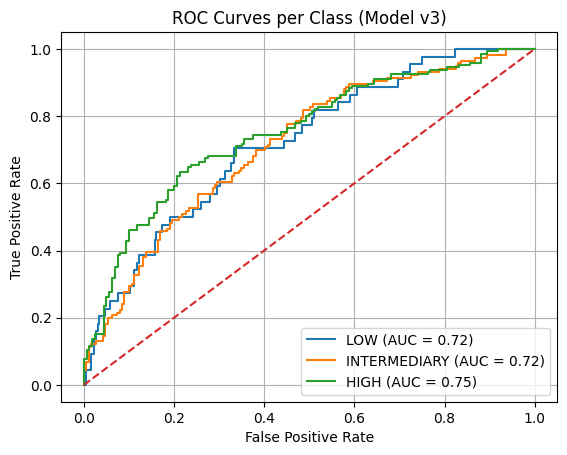

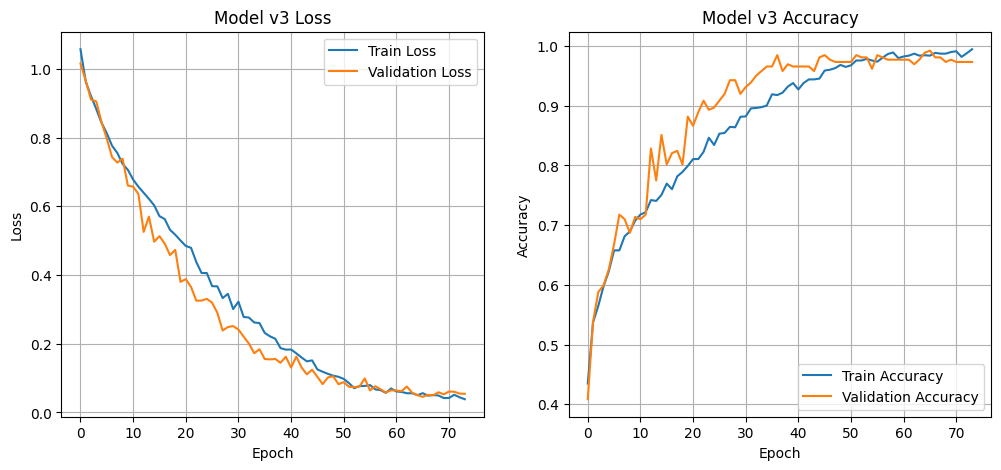

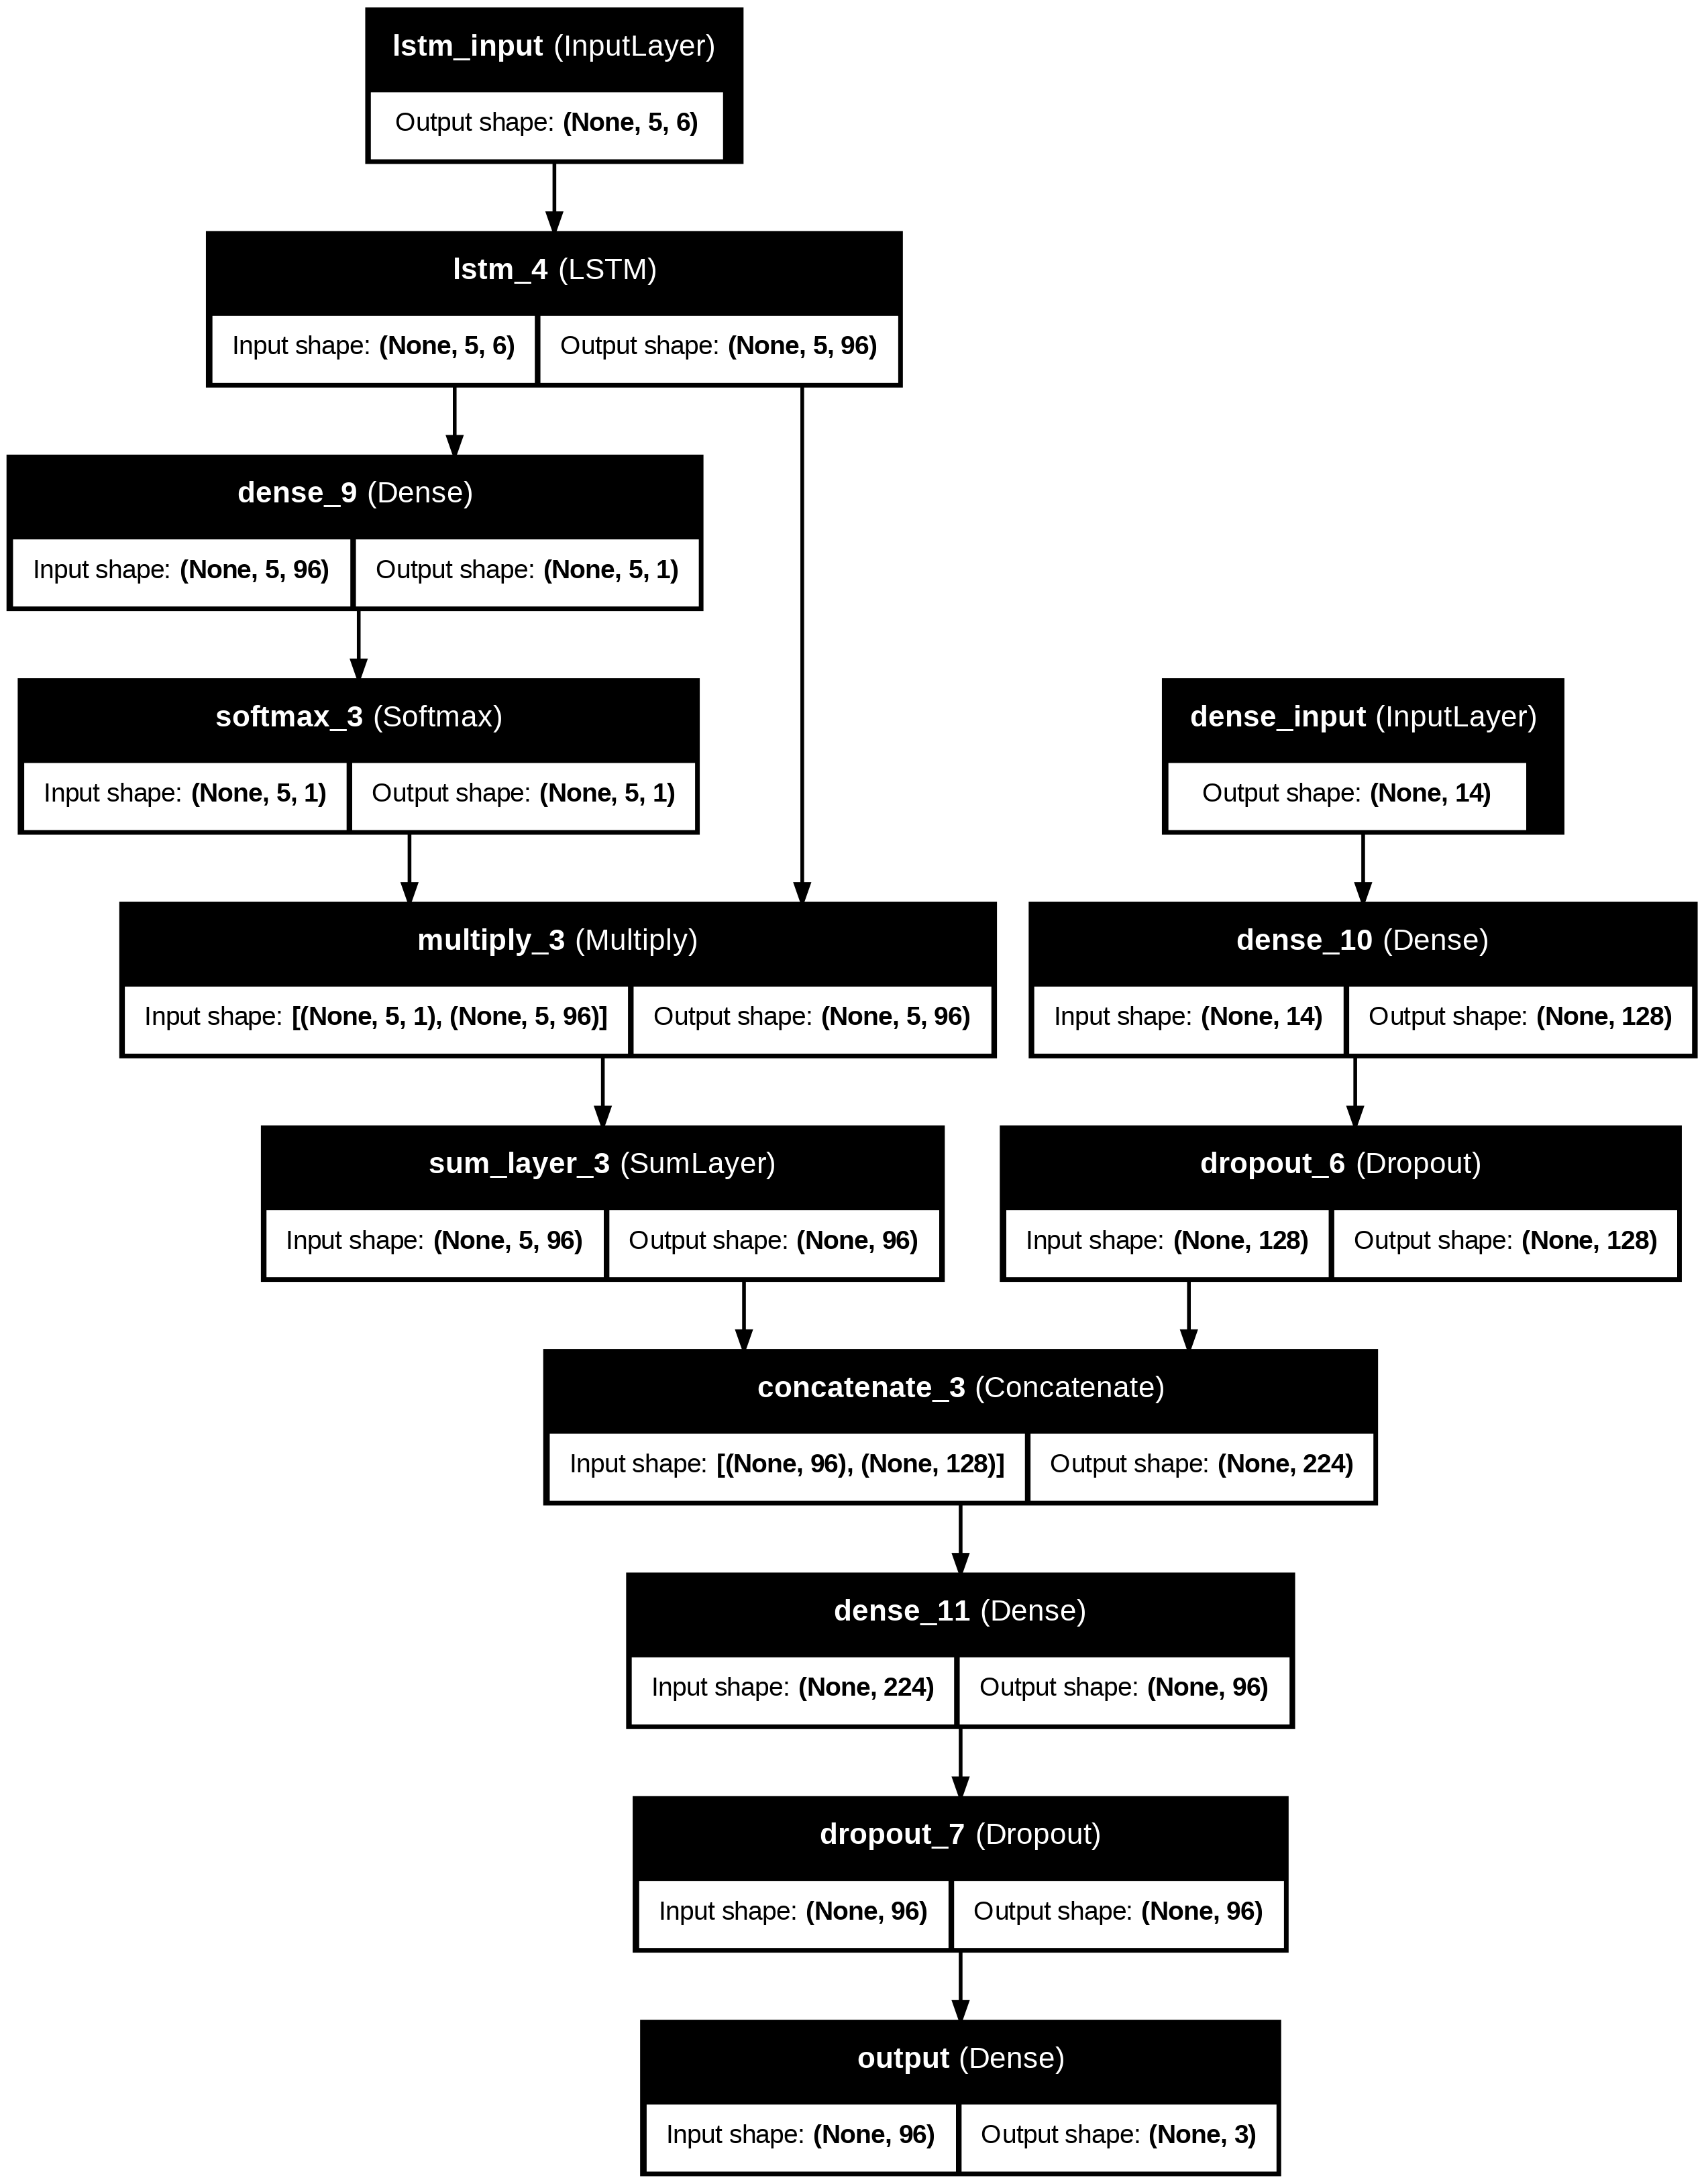

In [ ]:
# Build model with another architecture variation
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

class SumLayer(Layer):
    def call(self, inputs):
        return K.sum(inputs, axis=1)

def attention_layer(inputs):
    score_dense = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.keras.layers.Softmax(axis=1)(score_dense)
    context_vector = attention_weights * inputs
    context_vector = SumLayer()(context_vector)
    return context_vector

timesteps = X_seq_res.shape[1]
feat_l = X_seq_res.shape[2]
feat_d = X_den_res.shape[1]

inp_l = Input(shape=(timesteps, feat_l), name='lstm_input')
# Changed LSTM units
l = LSTM(96, return_sequences=True)(inp_l)
context = attention_layer(l)

inp_d = Input(shape=(feat_d,), name='dense_input')
# Changed Dense units and dropout
d = Dense(128, activation='relu')(inp_d)
d = Dropout(0.3)(d)

combined = concatenate([context, d])
# Changed Dense units and dropout
combined = Dense(96, activation='relu')(combined)
combined = Dropout(0.3)(combined)
out = Dense(3, activation='softmax', name='output')(combined)

model_v3 = Model(inputs=[inp_l, inp_d], outputs=out)

# Using the optimal learning rate found earlier
model_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_v3.summary()

# Train the new model
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

history_v3 = model_v3.fit(
    {'lstm_input': X_seq_res, 'dense_input': X_den_res}, y_res,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es, rl],
    class_weight=class_weights
)

# Evaluate the new model
preds_v3 = model_v3.predict({'lstm_input': X_test_seq, 'dense_input': X_test_den})
pred_labels_v3 = np.argmax(preds_v3, axis=1)

print("Evaluation of Model v3:")
print(classification_report(y_test, pred_labels_v3, target_names=['LOW','INTERMEDIARY','HIGH']))
print('Confusion matrix:\n', confusion_matrix(y_test, pred_labels_v3))

# Plot ROC for the new model
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure()
for i,cls in enumerate(['LOW','INTERMEDIARY','HIGH']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], preds_v3[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (Model v3)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history for the new model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.title('Model v3 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model v3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot model architecture for the new model
tf.keras.utils.plot_model(model_v3, show_shapes=True, show_layer_names=True, expand_nested=True)

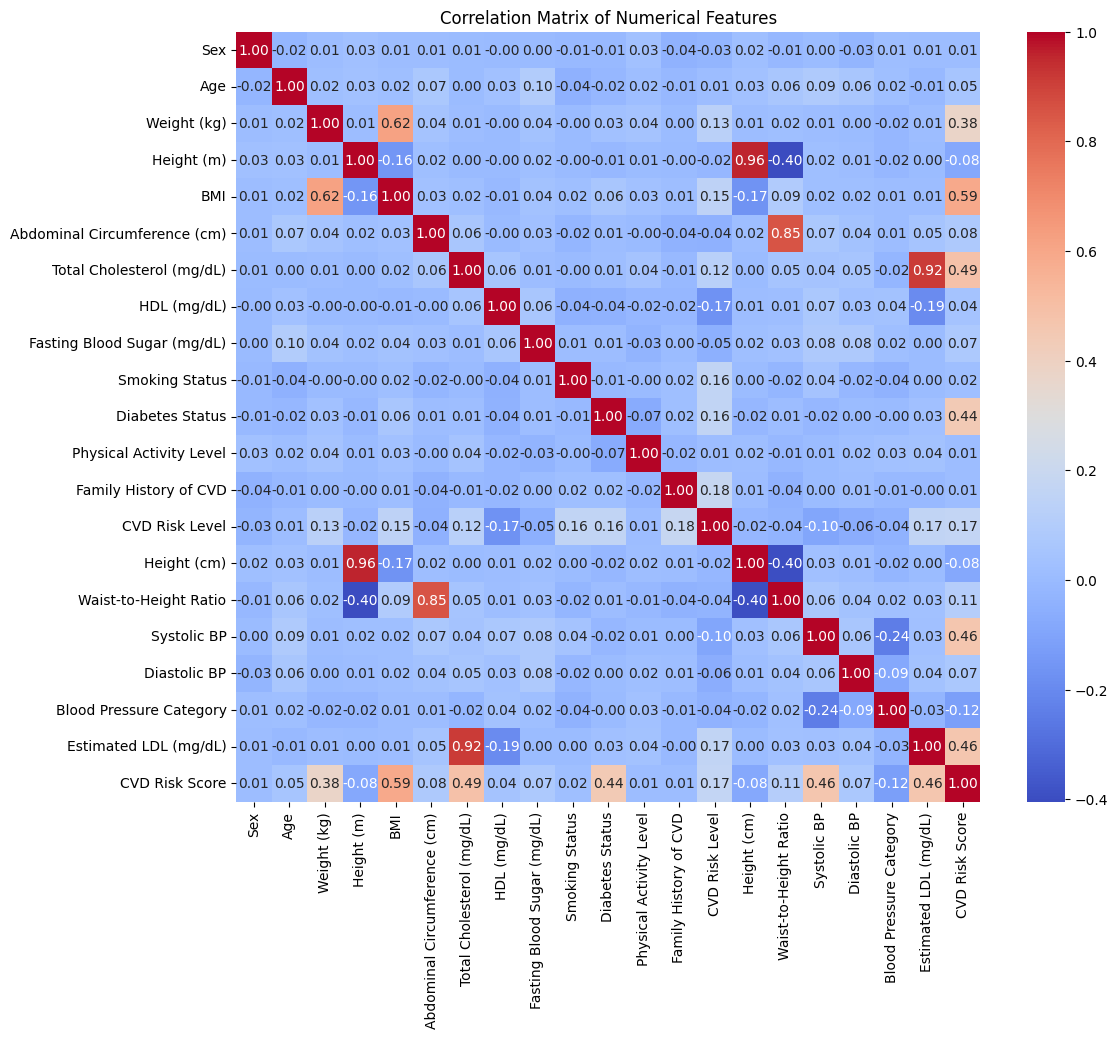

In [ ]:
# Analyze Existing Features: Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation analysis
df_numeric = df_proc.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Create New Features

### Subtask:
Engineer new features based on existing ones to potentially improve model performance.

**Reasoning**:
Based on the correlation matrix and common feature engineering techniques for health data, I will create the following new features:
- **Age and BMI Interaction:** The interaction between age and BMI might be a stronger indicator of risk than either feature alone.
- **BMI Squared:** A polynomial feature for BMI to capture potential non-linear relationships.
- **Ratio of Total Cholesterol to HDL:** This ratio is often considered a significant risk factor for CVD.

In [ ]:
# Create new features
df_feat_eng = df_proc.copy()

# Age and BMI Interaction
if 'Age' in df_feat_eng.columns and 'BMI' in df_feat_eng.columns:
    df_feat_eng['Age_BMI_Interaction'] = df_feat_eng['Age'] * df_feat_eng['BMI']

# BMI Squared
if 'BMI' in df_feat_eng.columns:
    df_feat_eng['BMI_Squared'] = df_feat_eng['BMI']**2

# Ratio of Total Cholesterol to HDL
if 'Total Cholesterol (mg/dL)' in df_feat_eng.columns and 'HDL (mg/dL)' in df_feat_eng.columns:
    # Add a small value to HDL to avoid division by zero
    df_feat_eng['Cholesterol_to_HDL_Ratio'] = df_feat_eng['Total Cholesterol (mg/dL)'] / (df_feat_eng['HDL (mg/dL)'] + 1e-6)

print("New features created:")
print(df_feat_eng[['Age_BMI_Interaction', 'BMI_Squared', 'Cholesterol_to_HDL_Ratio']].head())

# Update dense features list to include new features
dense_features_fe = dense_features + ['Age_BMI_Interaction', 'BMI_Squared', 'Cholesterol_to_HDL_Ratio']
# Filter to only include features present in the dataframe
dense_features_fe = [f for f in dense_features_fe if f in df_feat_eng.columns]
print("\nUpdated dense features list (first 20):")
print(dense_features_fe[:20])

New features created:
   Age_BMI_Interaction  BMI_Squared  Cholesterol_to_HDL_Ratio
0                755.2       556.96                  3.179487
1               2288.0      1730.56                  3.240000
2               1237.4       723.61                  1.410959
3               1469.6      1115.56                  2.913043
4                921.6       829.44                  2.281250

Updated dense features list (first 20):
['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Height (cm)', 'Waist-to-Height Ratio', 'Blood Pressure Category', 'CVD Risk Score', 'Age_BMI_Interaction', 'BMI_Squared', 'Cholesterol_to_HDL_Ratio']


In [ ]:
# Re-run data splitting and scaling with the new dense features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np # Ensure numpy is imported if not already

# Update X_den to use the dataframe with engineered features
X_den_fe = df_feat_eng[dense_features_fe].values
y_fe = df_feat_eng['CVD Risk Level'].values

# Re-split the data
X_train_seq_fe, X_test_seq_fe, X_train_den_fe, X_test_den_fe, y_train_fe, y_test_fe = train_test_split(
    X_seq, X_den_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe) # Note: Using X_seq which was created before FE

# Re-scale the data
samps_fe, tim_fe, feats_fe = X_train_seq_fe.shape
scaler_seq_fe = StandardScaler()
X_train_seq_2d_fe = X_train_seq_fe.reshape((samps_fe, tim_fe*feats_fe))
X_test_seq_2d_fe = X_test_seq_fe.reshape((X_test_seq_fe.shape[0], tim_fe*feats_fe))
X_train_seq_fe_2d = scaler_seq_fe.fit_transform(X_train_seq_2d_fe)
X_test_seq_fe_2d = scaler_seq_fe.transform(X_test_seq_2d_fe)
X_train_seq_fe = X_train_seq_fe_2d.reshape((samps_fe, tim_fe, feats_fe))
X_test_seq_fe = X_test_seq_fe_2d.reshape((X_test_seq_fe.shape[0], tim_fe, feats_fe))

scaler_den_fe = StandardScaler()
X_train_den_fe = scaler_den_fe.fit_transform(X_train_den_fe)
X_test_den_fe = scaler_den_fe.transform(X_test_den_fe)
print('Prepared shapes with engineered features:', X_train_seq_fe.shape, X_train_den_fe.shape)

ValueError: Found input variables with inconsistent numbers of samples: [1525, 1529, 1529]

In [ ]:
# Apply SMOTE on flattened seq+dense with engineered features
from imblearn.over_sampling import SMOTE

X_train_flat_seq_fe = X_train_seq_fe.reshape((X_train_seq_fe.shape[0], -1))
X_smote_in_fe = np.concatenate([X_train_flat_seq_fe, X_train_den_fe], axis=1)
sm_fe = SMOTE(random_state=42)
X_res_fe, y_res_fe = sm_fe.fit_resample(X_smote_in_fe, y_train_fe)

# split back
n_seq_flat_fe = X_train_flat_seq_fe.shape[1]
X_seq_res_flat_fe = X_res_fe[:, :n_seq_flat_fe]
X_den_res_fe = X_res_fe[:, n_seq_flat_fe:]
X_seq_res_fe = X_seq_res_flat_fe.reshape((-1, SEQUENCE_LENGTH, feats_fe)) # Use SEQUENCE_LENGTH and feats_fe
print('Resampled shapes with engineered features:', X_seq_res_fe.shape, X_den_res_fe.shape, y_res_fe.shape)

NameError: name 'X_train_seq_fe' is not defined

In [ ]:
# compute class weights with engineered features
from sklearn.utils import class_weight
class_weights_fe = class_weight.compute_class_weight('balanced', classes=np.unique(y_res_fe), y=y_res_fe)
class_weights_fe = dict(enumerate(class_weights_fe))
print("Class weights with engineered features:", class_weights_fe)

NameError: name 'y_res_fe' is not defined

In [ ]:
# Build Model v3 with engineered features data shape and train
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported

class SumLayer(Layer):
    def call(self, inputs):
        return K.sum(inputs, axis=1)

def attention_layer(inputs):
    score_dense = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.keras.layers.Softmax(axis=1)(score_dense)
    context_vector = attention_weights * inputs
    context_vector = SumLayer()(context_vector)
    return context_vector

# Use the shapes from the data with engineered features
timesteps_fe = X_seq_res_fe.shape[1]
feat_l_fe = X_seq_res_fe.shape[2]
feat_d_fe = X_den_res_fe.shape[1]

inp_l_fe = Input(shape=(timesteps_fe, feat_l_fe), name='lstm_input_fe')
l_fe = LSTM(96, return_sequences=True)(inp_l_fe)
context_fe = attention_layer(l_fe)

inp_d_fe = Input(shape=(feat_d_fe,), name='dense_input_fe')
d_fe = Dense(128, activation='relu')(inp_d_fe)
d_fe = Dropout(0.3)(d_fe)

combined_fe = concatenate([context_fe, d_fe])
combined_fe = Dense(96, activation='relu')(combined_fe)
combined_fe = Dropout(0.3)(combined_fe)
out_fe = Dense(3, activation='softmax', name='output_fe')(combined_fe)

model_v3_fe = Model(inputs=[inp_l_fe, inp_d_fe], outputs=out_fe)

model_v3_fe.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_v3_fe.summary()

# Train the new model with engineered features data
es_fe = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl_fe = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

history_v3_fe = model_v3_fe.fit(
    {'lstm_input_fe': X_seq_res_fe, 'dense_input_fe': X_den_res_fe}, y_res_fe,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es_fe, rl_fe],
    class_weight=class_weights_fe
)

# Evaluate the new model with engineered features
preds_v3_fe = model_v3_fe.predict({'lstm_input_fe': X_test_seq_fe, 'dense_input_fe': X_test_den_fe})
pred_labels_v3_fe = np.argmax(preds_v3_fe, axis=1)

print("Evaluation of Model v3 with Engineered Features:")
print(classification_report(y_test_fe, pred_labels_v3_fe, target_names=['LOW','INTERMEDIARY','HIGH']))
print('Confusion matrix:\n', confusion_matrix(y_test_fe, pred_labels_v3_fe))

# Plot ROC for the new model with engineered features
y_test_bin_fe = label_binarize(y_test_fe, classes=[0,1,2])
plt.figure()
for i,cls in enumerate(['LOW','INTERMEDIARY','HIGH']):
    fpr_fe, tpr_fe, _fe = roc_curve(y_test_bin_fe[:,i], preds_v3_fe[:,i])
    roc_auc_fe = auc(fpr_fe,tpr_fe)
    plt.plot(fpr_fe, tpr_fe, label=f'{cls} (AUC = {roc_auc_fe:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (Model v3 with Engineered Features)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history for the new model with engineered features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_v3_fe.history['loss'], label='Train Loss')
plt.plot(history_v3_fe.history['val_loss'], label='Validation Loss')
plt.title('Model v3 with FE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_v3_fe.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3_fe.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model v3 with FE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot model architecture for the new model (should be same as v3 but with updated input shape for dense)
tf.keras.utils.plot_model(model_v3_fe, show_shapes=True, show_layer_names=True, expand_nested=True)

NameError: name 'X_seq_res_fe' is not defined

In [ ]:
# Load and Preprocess Data (Re-executing initial preprocessing)
import os, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder

path = 'CVD Dataset.csv'
df = pd.read_csv(path)

cat_cols = ['Sex','Smoking Status','Diabetes Status','Physical Activity Level','Family History of CVD','Blood Pressure Category']
df_proc = df.copy()
for c in cat_cols:
    if c in df_proc.columns:
        df_proc[c] = LabelEncoder().fit_transform(df_proc[c].astype(str))

df_proc['CVD Risk Level'] = df_proc['CVD Risk Level'].map({'LOW':0, 'INTERMEDIARY':1, 'HIGH':2})
if 'Blood Pressure (mmHg)' in df_proc.columns:
    df_proc = df_proc.drop(columns=['Blood Pressure (mmHg)'])

num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    df_proc[c] = df_proc[c].fillna(df_proc[c].median())

print('Data preprocessed.')

Data preprocessed.


In [ ]:
# Create New Features (Re-executing feature engineering)

# Age and BMI Interaction
if 'Age' in df_proc.columns and 'BMI' in df_proc.columns:
    df_proc['Age_BMI_Interaction'] = df_proc['Age'] * df_proc['BMI']

# BMI Squared
if 'BMI' in df_proc.columns:
    df_proc['BMI_Squared'] = df_proc['BMI']**2

# Ratio of Total Cholesterol to HDL
if 'Total Cholesterol (mg/dL)' in df_proc.columns and 'HDL (mg/dL)' in df_proc.columns:
    df_proc['Cholesterol_to_HDL_Ratio'] = df_proc['Total Cholesterol (mg/dL)'] / (df_proc['HDL (mg/dL)'] + 1e-6)

print("New features created in df_proc.")
print(df_proc[['Age_BMI_Interaction', 'BMI_Squared', 'Cholesterol_to_HDL_Ratio']].head())

New features created in df_proc.
   Age_BMI_Interaction  BMI_Squared  Cholesterol_to_HDL_Ratio
0                755.2       556.96                  3.179487
1               2288.0      1730.56                  3.240000
2               1237.4       723.61                  1.410959
3               1469.6      1115.56                  2.913043
4                921.6       829.44                  2.281250


In [ ]:
# Define Features Lists (Update with engineered features)

# Sequence feature candidates remain the same
seq_feature_candidates = ['Systolic BP','Diastolic BP','Fasting Blood Sugar (mg/dL)','Total Cholesterol (mg/dL)','HDL (mg/dL)','Estimated LDL (mg/dL)']
seq_features = [f for f in seq_feature_candidates if f in df_proc.columns] # Ensure they are still in the processed df

# Dense features now include engineered features
# Start with all columns in df_proc that are not sequence features or the target
all_possible_dense = [c for c in df_proc.columns if c not in seq_features + ['CVD Risk Level']]

# Filter this list to ensure only numerical or encoded categorical features are included
# We need to be careful here - after encoding, categorical columns become numerical.
# The engineered features are also numerical.
# Let's explicitly list the original dense features (excluding the ones that became sequence features or were dropped)
original_dense_candidates = ['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)',
                             'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD',
                             'Height (cm)', 'Waist-to-Height Ratio', 'Blood Pressure Category', 'CVD Risk Score']

# Now, add the engineered features to this list
engineered_features_list = ['Age_BMI_Interaction', 'BMI_Squared', 'Cholesterol_to_HDL_Ratio']

# Combine and ensure they are all in df_proc and are numerical after preprocessing/engineering
dense_features_fe = [f for f in (original_dense_candidates + engineered_features_list) if f in df_proc.columns and df_proc[f].dtype != 'object']


print('Sequence features:', seq_features)
print('Dense features (first 20) including engineered:', dense_features_fe[:20])

Sequence features: ['Systolic BP', 'Diastolic BP', 'Fasting Blood Sugar (mg/dL)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Estimated LDL (mg/dL)']
Dense features (first 20) including engineered: ['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Height (cm)', 'Waist-to-Height Ratio', 'Blood Pressure Category', 'CVD Risk Score', 'Age_BMI_Interaction', 'BMI_Squared', 'Cholesterol_to_HDL_Ratio']


In [ ]:
# Create sequences with engineered features
SEQUENCE_LENGTH = 5  # Use the same sequence length as before
sequences_X_fe = []
sequences_D_fe = []
sequences_y_fe = []

# Re-evaluate if real sequences can be used based on the updated df_proc
possible_id_cols_fe = [c for c in df_proc.columns if 'id' in c.lower() or 'patient' in c.lower()]
possible_time_cols_fe = [c for c in df_proc.columns if 'time' in c.lower() or 'date' in c.lower() or 'visit' in c.lower()]
USE_REAL_SEQUENCES_fe = len(possible_id_cols_fe)>0 and len(possible_time_cols_fe)>0

if USE_REAL_SEQUENCES_fe:
    pid_fe = possible_id_cols_fe[0]
    tcol_fe = possible_time_cols_fe[0]
    df_sorted_fe = df_proc.sort_values([pid_fe, tcol_fe])
    for key, g in df_sorted_fe.groupby(pid_fe):
        arr_seq_fe = g[seq_features].values
        arr_den_fe = g[dense_features_fe].values # Use dense_features_fe
        for i in range(0, len(g)-SEQUENCE_LENGTH+1):
            sequences_X_fe.append(arr_seq_fe[i:i+SEQUENCE_LENGTH])
            sequences_D_fe.append(arr_den_fe[i+SEQUENCE_LENGTH-1])
            sequences_y_fe.append(g['CVD Risk Level'].values[i+SEQUENCE_LENGTH-1])
else:
    # Use the logic for pseudo-sequences as before, but with the updated df_proc and feature lists
    if 'Sex' in df_proc.columns and 'Age' in df_proc.columns:
        df_sorted_fe = df_proc.sort_values(['Sex','Age']).reset_index(drop=True)
    else:
        df_sorted_fe = df_proc.reset_index(drop=True)
    arr_seq_all_fe = df_sorted_fe[seq_features].values # Use seq_features
    arr_den_all_fe = df_sorted_fe[dense_features_fe].values # Use dense_features_fe
    labels_all_fe = df_sorted_fe['CVD Risk Level'].values
    for i in range(0, len(df_sorted_fe)-SEQUENCE_LENGTH+1):
        sequences_X_fe.append(arr_seq_all_fe[i:i+SEQUENCE_LENGTH])
        sequences_D_fe.append(arr_den_all_fe[i+SEQUENCE_LENGTH-1])
        sequences_y_fe.append(labels_all_fe[i+SEQUENCE_LENGTH-1])


X_seq_fe = np.array(sequences_X_fe)
X_den_fe = np.array(sequences_D_fe)
y_fe = np.array(sequences_y_fe)
print('Sequences created with engineered features:', X_seq_fe.shape, X_den_fe.shape, y_fe.shape)

Sequences created with engineered features: (1525, 5, 6) (1525, 17) (1525,)


In [ ]:
# Fallback to timesteps=1 if too few sequences (with engineered features)
if X_seq_fe.shape[0] < 50:
    print('Too few sequences; falling back to timesteps=1 on full dataset with engineered features')
    X_seq_fe = df_proc[seq_features].values.reshape((-1,1,len(seq_features)))
    X_den_fe = df_proc[dense_features_fe].values # Use dense_features_fe
    y_fe = df_proc['CVD Risk Level'].values
    SEQUENCE_LENGTH = 1
    print('New shapes with engineered features:', X_seq_fe.shape, X_den_fe.shape, y_fe.shape)

In [ ]:
# Train/test split and scaling with engineered features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_seq_fe, X_test_seq_fe, X_train_den_fe, X_test_den_fe, y_train_fe, y_test_fe = train_test_split(
    X_seq_fe, X_den_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe)

# Scale the data
samps_fe, tim_fe, feats_fe = X_train_seq_fe.shape
scaler_seq_fe = StandardScaler()
X_train_seq_2d_fe = X_train_seq_fe.reshape((samps_fe, tim_fe*feats_fe))
X_test_seq_2d_fe = X_test_seq_fe.reshape((X_test_seq_fe.shape[0], tim_fe*feats_fe))
X_train_seq_fe_scaled = scaler_seq_fe.fit_transform(X_train_seq_2d_fe).reshape(samps_fe, tim_fe, feats_fe)
X_test_seq_fe_scaled = scaler_seq_fe.transform(X_test_seq_2d_fe).reshape(X_test_seq_fe.shape[0], tim_fe, feats_fe)


scaler_den_fe = StandardScaler()
X_train_den_fe_scaled = scaler_den_fe.fit_transform(X_train_den_fe)
X_test_den_fe_scaled = scaler_den_fe.transform(X_test_den_fe)

print('Prepared shapes with engineered features:', X_train_seq_fe_scaled.shape, X_train_den_fe_scaled.shape)

Prepared shapes with engineered features: (1220, 5, 6) (1220, 17)


In [ ]:
# Apply SMOTE on flattened seq+dense with engineered features
from imblearn.over_sampling import SMOTE
import numpy as np # Ensure numpy is imported

X_train_flat_seq_fe = X_train_seq_fe_scaled.reshape((X_train_seq_fe_scaled.shape[0], -1))
X_smote_in_fe = np.concatenate([X_train_flat_seq_fe, X_train_den_fe_scaled], axis=1)
sm_fe = SMOTE(random_state=42)
X_res_fe, y_res_fe = sm_fe.fit_resample(X_smote_in_fe, y_train_fe)

# split back
n_seq_flat_fe = X_train_flat_seq_fe.shape[1]
X_seq_res_flat_fe = X_res_fe[:, :n_seq_flat_fe]
X_den_res_fe = X_res_fe[:, n_seq_flat_fe:]
X_seq_res_fe = X_seq_res_flat_fe.reshape((-1, SEQUENCE_LENGTH, feats_fe)) # Use SEQUENCE_LENGTH and feats_fe
print('Resampled shapes with engineered features:', X_seq_res_fe.shape, X_den_res_fe.shape, y_res_fe.shape)

Resampled shapes with engineered features: (1746, 5, 6) (1746, 17) (1746,)


In [ ]:
# compute class weights with engineered features
from sklearn.utils import class_weight
import numpy as np # Ensure numpy is imported
class_weights_fe = class_weight.compute_class_weight('balanced', classes=np.unique(y_res_fe), y=y_res_fe)
class_weights_fe = dict(enumerate(class_weights_fe))
print("Class weights with engineered features:", class_weights_fe)

Class weights with engineered features: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input_fe       │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 5, 96)     │     39,552 │ lstm_input_fe[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 5, 1)      │         97 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_4 (Softmax) │ (None, 5, 1)      │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_input_fe      │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 5, 96)     │          0 │ softmax_4[0][0],  │
│ (Multiply)          │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │      2,304 │ dense_input_fe[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_layer_4         │ (None, 96)        │          0 │ multiply_4[0][0]  │
│ (SumLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 224)       │          0 │ sum_layer_4[0][0… │
│ (Concatenate)       │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 96)        │     21,600 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 96)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_fe (Dense)   │ (None, 3)         │        291 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,844 (249.39 KB)

 Trainable params: 63,844 (249.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3730 - loss: 1.1130 - val_accuracy: 0.4351 - val_loss: 1.0293 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5454 - loss: 0.9581 - val_accuracy: 0.5611 - val_loss: 0.9276 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5786 - loss: 0.9117 - val_accuracy: 0.5763 - val_loss: 0.9231 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5887 - loss: 0.8715 - val_accuracy: 0.6527 - val_loss: 0.8573 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6288 - loss: 0.8385 - val_accuracy: 0.7176 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6839 - loss: 0.7893 - val_accuracy: 0.7099 - val_loss: 0.7250 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6785 - loss: 0.7761 - val_ac

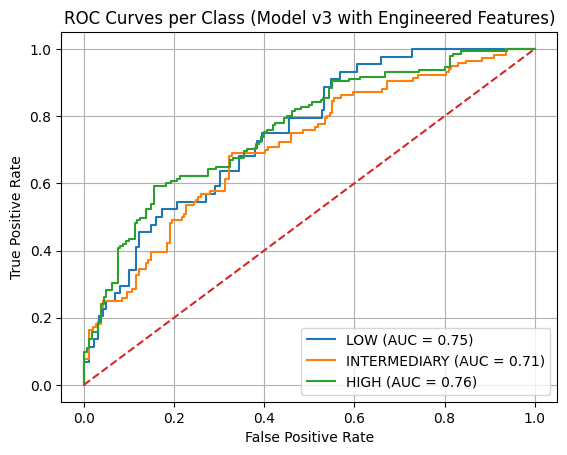

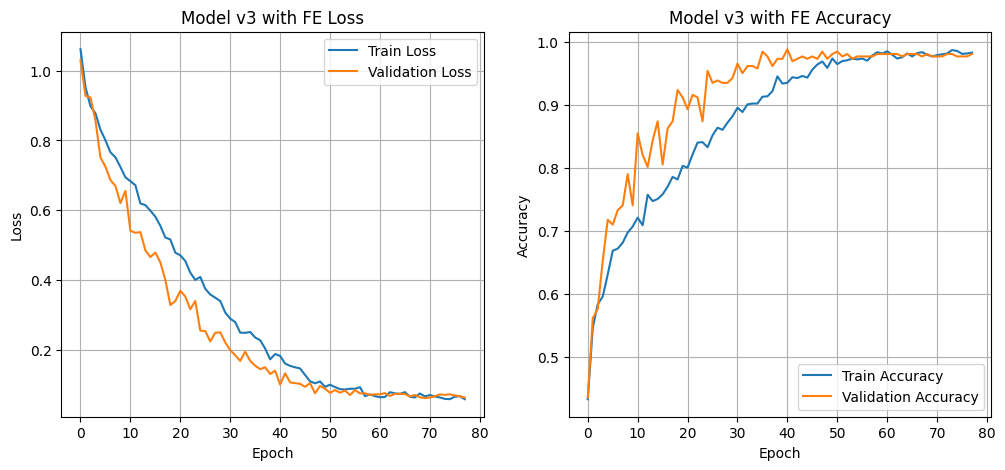

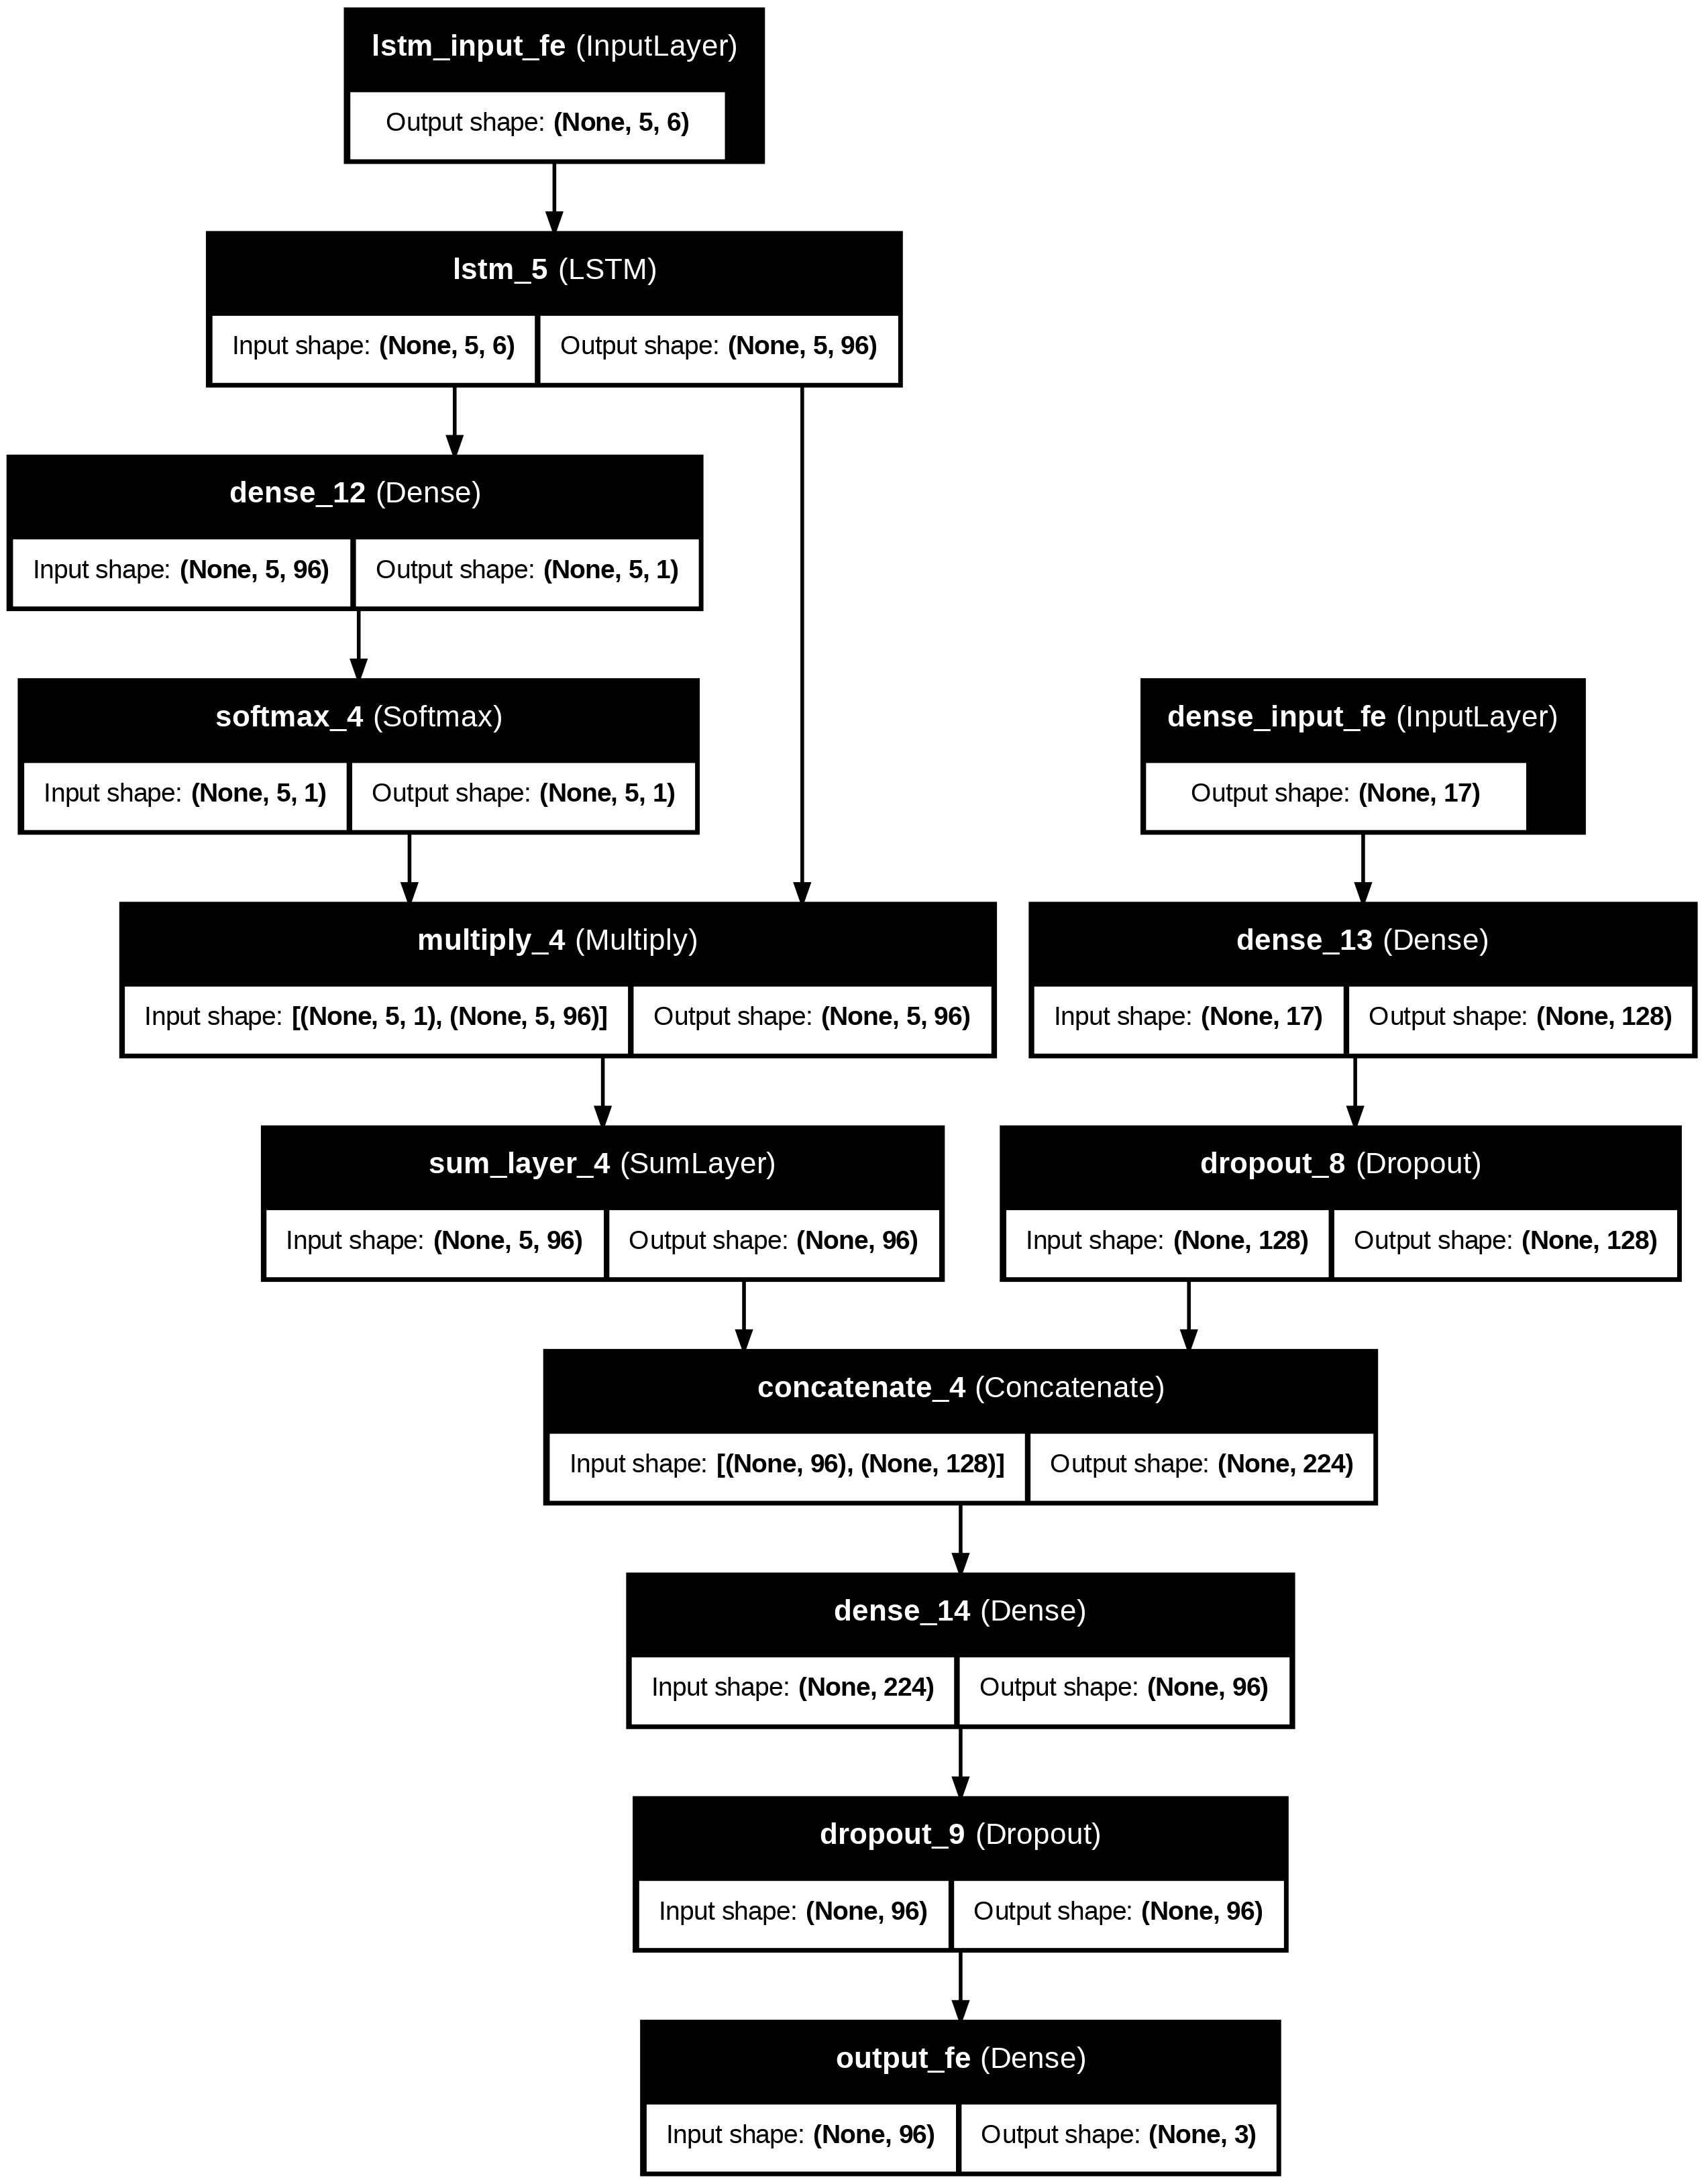

In [ ]:
# Build Model v3 with engineered features data shape and train
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported

class SumLayer(Layer):
    def call(self, inputs):
        return K.sum(inputs, axis=1)

def attention_layer(inputs):
    score_dense = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.keras.layers.Softmax(axis=1)(score_dense)
    context_vector = attention_weights * inputs
    context_vector = SumLayer()(context_vector)
    return context_vector

# Use the shapes from the data with engineered features
timesteps_fe = X_seq_res_fe.shape[1]
feat_l_fe = X_seq_res_fe.shape[2]
feat_d_fe = X_den_res_fe.shape[1]

inp_l_fe = Input(shape=(timesteps_fe, feat_l_fe), name='lstm_input_fe')
l_fe = LSTM(96, return_sequences=True)(inp_l_fe)
context_fe = attention_layer(l_fe)

inp_d_fe = Input(shape=(feat_d_fe,), name='dense_input_fe')
d_fe = Dense(128, activation='relu')(inp_d_fe)
d_fe = Dropout(0.3)(d_fe)

combined_fe = concatenate([context_fe, d_fe])
combined_fe = Dense(96, activation='relu')(combined_fe)
combined_fe = Dropout(0.3)(combined_fe)
out_fe = Dense(3, activation='softmax', name='output_fe')(combined_fe)

model_v3_fe = Model(inputs=[inp_l_fe, inp_d_fe], outputs=out_fe)

model_v3_fe.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_v3_fe.summary()

# Train the new model with engineered features data
es_fe = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl_fe = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

history_v3_fe = model_v3_fe.fit(
    {'lstm_input_fe': X_seq_res_fe, 'dense_input_fe': X_den_res_fe}, y_res_fe,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es_fe, rl_fe],
    class_weight=class_weights_fe
)

# Evaluate the new model with engineered features
preds_v3_fe = model_v3_fe.predict({'lstm_input_fe': X_test_seq_fe_scaled, 'dense_input_fe': X_test_den_fe_scaled})
pred_labels_v3_fe = np.argmax(preds_v3_fe, axis=1)

print("Evaluation of Model v3 with Engineered Features:")
print(classification_report(y_test_fe, pred_labels_v3_fe, target_names=['LOW','INTERMEDIARY','HIGH']))
print('Confusion matrix:\n', confusion_matrix(y_test_fe, pred_labels_v3_fe))

# Plot ROC for the new model with engineered features
y_test_bin_fe = label_binarize(y_test_fe, classes=[0,1,2])
plt.figure()
for i,cls in enumerate(['LOW','INTERMEDIARY','HIGH']):
    fpr_fe, tpr_fe, _fe = roc_curve(y_test_bin_fe[:,i], preds_v3_fe[:,i])
    roc_auc_fe = auc(fpr_fe,tpr_fe)
    plt.plot(fpr_fe, tpr_fe, label=f'{cls} (AUC = {roc_auc_fe:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (Model v3 with Engineered Features)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history for the new model with engineered features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_v3_fe.history['loss'], label='Train Loss')
plt.plot(history_v3_fe.history['val_loss'], label='Validation Loss')
plt.title('Model v3 with FE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_v3_fe.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3_fe.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model v3 with FE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot model architecture for the new model (should be same as v3 but with updated input shape for dense)
tf.keras.utils.plot_model(model_v3_fe, show_shapes=True, show_layer_names=True, expand_nested=True)